# main classifiers

see also for LDA
https://colab.research.google.com/drive/1Y4Twmv6xIAHEuaAXOKQXdbVBx42givRm#scrollTo=QMYk4OHr3meM


#Pubmed text analysis


In [ ]:
# !git clone https://github.com/SannapaneniBharadwaj/PUBMED_Text_Analysis.git

# **Tutorial** - Topic Modeling with BERTopic
(last updated 01-09-2022)

In this tutorial we will be exploring how to use BERTopic to create topics from the well-known 20Newsgroups dataset. The most frequent use-cases and methods are discussed together with important parameters to keep a look out for.


## BERTopic
BERTopic is a topic modeling technique that leverages 🤗 transformers and a custom class-based TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

<br>

<img src="https://raw.githubusercontent.com/MaartenGr/BERTopic/master/images/logo.png" width="40%">

# Enabling the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

[Reference](https://colab.research.google.com/notebooks/gpu.ipynb)

#pyresearchinsights

In [ ]:
!pip install pyResearchInsights

In [ ]:
import csv

def extract_abstracts(input_csv_file, output_txt_file):
    try:
        # Open the CSV file for reading
        with open(input_csv_file, 'r', newline='',encoding='ISO-8859-1') as csv_file:
            # csv_reader = csv.reader(csv_file)
            csv_reader = csv.DictReader(csv_file)

            # Open the text file for writing
            with open(output_txt_file, 'w', encoding='utf-8') as txt_file:
                for row in csv_reader:
                    # Assuming the abstract is in the second column (index 1)
                    abstract = row['Abstract']
                    # Write the abstract to the text file
                    txt_file.write(abstract + '\n\n')  # Add a line space between abstracts

        print("Abstracts extracted and saved to", output_txt_file)
    except Exception as e:
        print("An error occurred:", str(e))

# Example usage:
input_csv_file = 'review_243232_irrelevant_csv_20230909042812_processed.csv'  # Replace with your CSV file name
output_txt_file = 'Abstract_ANALYTICAL.txt'  # Replace with your desired output file name
extract_abstracts(input_csv_file, output_txt_file)

Abstracts extracted and saved to Abstract_ANALYTICAL.txt


In [ ]:
from pyResearchInsights.Cleaner import cleaner_main

abstracts_log_name = "Abstract_ANALYTICAL.txt"
status_logger_name = "test_run"
cleaner_main(abstracts_log_name, status_logger_name)

In [ ]:
import pandas as pd

def read_non_empty_lines_to_df(file_path):
    lines = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if line:  # Check if the line is not empty
                lines.append(line)

    # Create a DataFrame with the non-empty lines
    df = pd.DataFrame({'Text': lines})
    return df

# Usage example:
file_path = '/content/Abstract_ANALYTICAL_CLEANED.txt'
result_df = read_non_empty_lines_to_df(file_path)
result_df

In [ ]:
cleaner_main

<function pyResearchInsights.Cleaner.cleaner_main(abstract_directory, status_logger_name)>

##Clean abstract

In [ ]:
def remove_words_from_abstracts(abstracts, words_to_remove):
    cleaned_abstracts = []

    for abstract in abstracts:
        # Convert abstract and words to lowercase for case-insensitive matching
        abstract_lower = abstract.lower()
        for word in words_to_remove:
            word_lower = word.lower()
            abstract_lower = abstract_lower.replace(word_lower, '')

        # Remove extra whitespace resulting from word removal
        abstract_cleaned = ' '.join(abstract_lower.split())
        cleaned_abstracts.append(abstract_cleaned)

    return cleaned_abstracts

# Example usage:
abstracts = [
    'background: This is the background of the study.',
    'objectives: The objectives of the research are...',
    'This is a regular abstract without specific headings.',
]

words_to_remove = ['Background:', 'Objectives:','Objective:','Object:','OBJECTIVES/HYPOTHESIS:','PURPOSE:','KEY POINTS:','BACKGROUND AND AIM OF THE STUDY:']
cleaned_abstracts = remove_words_from_abstracts(result_df['Text'], words_to_remove)


In [ ]:
len(cleaned_abstracts)

#PubmedBERT

In [ ]:
!pip install ftfy transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 832.3 kB/s eta 0:00:00


In [ ]:
import pandas as pd
import ftfy

# clean up weird characters
def fix_D_text(original_string):
  corrected_string = ftfy.fix_text(original_string)
  fixed = corrected_string.replace('\u2009',' ')
  return fixed


# test_df = pd.read_csv('review_243232_irrelevant_csv_20230909042812_processed.csv',encoding='ISO-8859-1')

test_df = pd.read_csv('topic_predictions_LDA.csv',encoding='utf-8')


# Apply the clean_text function to the specific column containing text with unwanted characters
test_df['abstract'] = test_df['abstract'].apply(fix_D_text)
test_df['articletitle'] = test_df['articletitle'].apply(fix_D_text)

# trim_df=test_df.head(2)

In [ ]:
# test_df['tokenized_c_abstract'][38]

print ("length of {} and eg abs:{}".format(len(test_df),test_df['abstract'][38]))



length of 1439 and eg abs:OBJECTIVE: The study aims to evaluate the reliability and the discriminative validity of surface electromyography (sEMG) in the assessment of patients with primary muscle tension dysphonia (MTD). STUDY DESIGN: The study design is cross-sectional. METHODS: Fifteen patients with primary MTD (mean age: 34.07 ± 10.99 years) and 15 healthy volunteers (mean age: 34.53 ± 10.63 years) were included. All participants underwent evaluation of sEMG to record the electrical activity of the thyrohyoid and cricothyroid muscles. The outcome measures were the root mean square (RMS), activity peak, duration, and time to the peak activity, which were obtained during /a/ and /i/ prolongation for test-retest reliability. RESULTS: The test-retest reliability was good to excellent for the RMS and peak activity measures (intraclass correlation coefficient [agreement] [ICC(agreement)] = 0.49-0.98). The reliability for the activity duration was poor to excellent (ICC(agreement) = 0.19-

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import re

def classify_papersv2(papers, tokenizer, model):
    regexp_tag = r'\<andsystem\-candidate\>'

    for i,paper in papers.iterrows():
        # Combine title, abstract, and keywords (if available)

        pmid=paper['pmid']
        abstract = paper["cleaned_abstract"]+ paper["journaltitle"]
        input_seq = tokenizer.encode( abstract, add_special_tokens = True )

        if ( len( input_seq ) < 512 ):
            inputs = tokenizer( abstract, return_tensors = "pt" )
            labels = torch.tensor( [ 1 ] ).unsqueeze( 0 )
            outputs = model( **inputs, labels = labels )

            predicition = outputs.logits.softmax( dim = -1 ).tolist()
        else:
            while len( input_seq ) >= 512:
                abstract_split = []
                abstract_split = nltk.sent_tokenize( abstract )
                lp2 = len( re.findall( regexp_tag, abstract_split[ -1 ] ) )

                if ( lp2 < 1 ):
                    abstract = abstract.replace( abstract_split[ -1 ], '' )
                else:
                    abstract = abstract.replace( abstract_split[ 0 ], '' )

                input_seq = tokenizer.encode( abstract, add_special_tokens = True )

            inputs = tokenizer( abstract, return_tensors = "pt" )
            labels = torch.tensor( [ 1 ] ).unsqueeze( 0 ) # Batch size 1
            outputs = model( **inputs, labels = labels )

            predicition = outputs.logits.softmax( dim = -1 ).tolist()

        print( str( pmid ), " ", predicition[ 0 ][ 0 ], " ", predicition[ 0 ][ 1 ] )
        pred=F.softmax(outputs.logits,dim=1)
        # print(torch.argmax(pred,dim=1))
    return predicition


#----------Model work
# model_name = "allenai/scibert_scivocab_uncased"

model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


results = classify_papersv2(test_df,tokenizer,model)

# Display the classification results
print(results)

In [ ]:
trim_df

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier=pipeline("text-classification", model=model, tokenizer=tokenizer)

res=classifier(test_df['cleaned_abstract'][0])

print(res)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'LABEL_1', 'score': 0.5600430369377136}]


In [ ]:
predicted_topic = res[0]['label']

# 'predicted_topic' now contains the predicted topic label
print(predicted_topic)

LABEL_1


In [ ]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load the PubMedBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Load the dataset of research paper abstracts and labels
research_papers = trim_df

# Preprocess the data
encoded_research_papers = tokenizer(research_papers["abstract"], padding=True, truncation=True)

# Predict the categories of the research papers
predictions = model(encoded_research_papers["input_ids"]).logits

# Get the most likely category for each research paper
predicted_categories = np.argmax(predictions, axis=1)

# Classify the research papers into different categories
research_paper_categories = []
for predicted_category in predicted_categories:
    research_paper_categories.append(research_papers.iloc[predicted_category]["category"])

# Print the classified research papers
print(research_papers)

In [ ]:
research_papers["Abstract"]


0    BACKGROUND: Effective hypertrophy-oriented res...
1    OBJECTIVE: Muscle tension dysphonia (MTD) is a...
Name: Abstract, dtype: object

# **Installing BERTopic**

We start by installing BERTopic from PyPi:

In [ ]:
%%capture
!pip install bertopic

## Restart the Notebook
After installing BERTopic, some packages that were already loaded were updated and in order to correctly use them, we should now restart the notebook.

From the Menu:

Runtime → Restart Runtime

# Data
For this example, we use the popular 20 Newsgroups dataset which contains roughly 18000 newsgroups posts

In [ ]:
# from sklearn.datasets import fetch_20newsgroups
# docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

#Get keywords from each abstract

In [ ]:
import pandas as pd
df = pd.read_csv('ALL_papers.csv',encoding='ISO-8859-1')
# df=test_df
def remove_words_from_abstracts(abstracts, words_to_remove):
    cleaned_abstracts = []

    for abstract in abstracts:
        # Convert abstract and words to lowercase for case-insensitive matching
        abstract_lower = abstract.lower()
        for word in words_to_remove:
            word_lower = word.lower()
            abstract_lower = abstract_lower.replace(word_lower, '')

        # Remove extra whitespace resulting from word removal
        abstract_cleaned = ' '.join(abstract_lower.split())
        cleaned_abstracts.append(abstract_cleaned)

    return cleaned_abstracts

words_to_remove = ['Background:', 'Objectives:','Objective:','Object:','OBJECTIVES/HYPOTHESIS:','PURPOSE:','KEY POINTS:','BACKGROUND AND AIM OF THE STUDY:']
cleaned_abstracts = remove_words_from_abstracts(df['Abstract'], words_to_remove)

df['abstract']=cleaned_abstracts

print('{} Abstracts loaded!'.format(len(df['abstract'])))

def contains_review(title):
    return 1 if 'review' in title.lower() else 0

df['contains_review'] = df['Title'].apply(contains_review)

# # Filter the DataFrame to select rows where 'contains_review' is equal to 1
# review_studies = df[df['contains_review'] == 1]
# data = df[df['contains_review'] == 0].reset_index()

# # Print the review studies
# print('{} review studies removed'.format(len(review_studies)))

data=df


1510 Abstracts loaded!


In [ ]:
df["Inclusion_Status"].unique()

array(['irrelevant', 'included', 'excluded'], dtype=object)

In [ ]:
filtered_df = df[(df['contains_review'] == 1) & (df['Inclusion_Status'] == 'irrelevant')]
filtered_df['Title']

from tabulate import tabulate
table = tabulate(filtered_df, headers='keys', tablefmt='pretty', showindex=False)
# Print the formatted table
print(table)

+----------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# process studies that are not reviews
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK stopwords (if not already downloaded)
nltk.download("stopwords")

# Import NLTK stopwords
from nltk.corpus import stopwords

# Load your dataset containing paper titles and abstracts as a Pandas DataFrame
# data = pd.read_csv('review_243232_irrelevant_csv_20230909042812_processed.csv',encoding='ISO-8859-1')

# Extract abstracts as a list
abstracts = data["abstract"].tolist()

# Create a TF-IDF vectorizer with custom stopwords
stop_words = set(stopwords.words("english"))  # English stopwords
tfidf_vectorizer = TfidfVectorizer(max_features=50, stop_words=list(stop_words))  # Adjust max_features as needed

# Fit and transform the abstracts
tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts)

# Get feature names (words)
feature_names = tfidf_vectorizer.get_feature_names_out()

# Initialize a list to store keywords for each abstract
keywords_per_abstract = []

# Loop through each abstract
for i, abstract in enumerate(abstracts):
    # Sort words by TF-IDF score in descending order
    sorted_indices = tfidf_matrix[i].toarray().argsort()[0][::-1]

    # Get the top N keywords (adjust N as needed)
    top_keywords = [feature_names[idx] for idx in sorted_indices[:5]]  # Extract top 5 keywords

    # Store the keywords in the list
    keywords_per_abstract.append(", ".join(top_keywords))

# Add the keywords back to the DataFrame or save them to a new file
data["KeywordZ"] = keywords_per_abstract
# data.to_csv("output_dataset_with_keywords.csv", index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data["KeywordZ"]

0                   training, methods, time, however, may
1        treatment, studies, tension, clinical, different
2             training, induced, however, muscle, effects
3              training, type, increase, muscle, activity
4             training, increase, activity, muscle, force
                              ...                        
1434               changes, muscles, human, muscle, using
1435          muscle, subjects, function, muscles, tissue
1436             muscle, force, muscles, model, different
1437      training, group, subjects, control, significant
1438    increase, significant, muscle, results, different
Name: KeywordZ, Length: 1439, dtype: object

In [ ]:
#testing for merging back values
# run at end!
#  lp=df
# df['new_keywords']='nan'
rows=data['index']
i=0;
for row in rows:
  df.loc[row, 'new_keywords'] = data["KeywordZ"][i]
  i+=1



In [ ]:
# df.to_csv("output_dataset_with_keywords.csv", index=False)

In [ ]:
# docs = data['Keywords']
docs = data['cleaned_abstract'].astype(str)

In [ ]:
docs[361]

'assess reactivity sarcoplasmic reticulum caffeine using skinned muscle fibre tension test compare reference vitro contracture test diagnosis malignant hyperthermia hm susceptibility laboratory investigation muscle biopsies patients including classified susceptible mh mhs classified non-susceptible mhn according criteria european north american mh groups reactivity caffeine halothane skinned muscle fibres compared according type fibres data vitro contracture test type fibres type oxidative slow type glycolytic fast determined strontium dose-response curves reactivity caffeine significantly lower mhs group type type ii skinned fibres however comparison data vitro contracture tests using roc curve analysis best sensitivity-specificity compromise - - type type ii skinned fibres respectively skinned muscle fibre tension test cannot used instead vitro contracture test diagnostic mhs however may strengthen data latter'

## get keywords using pubmedbert ??

In [ ]:
# ??
# from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertForSequenceClassification

# Load your dataset containing paper titles and abstracts as a Pandas DataFrame
# data = pd.read_csv('review_243232_irrelevant_csv_20230909042812_processed.csv',encoding='ISO-8859-1')

def testfunction(pmid, abstract):
    model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    model = BertForSequenceClassification.from_pretrained(model_name)
    tokenizer = BertTokenizer.from_pretrained(model_name)
    regexp_tag = r'\<andsystem\-candidate\>'

    input_seq = tokenizer.encode( abstract, add_special_tokens = True )

    if ( len( input_seq ) < 512 ):
        inputs = tokenizer( abstract, return_tensors = "pt" )
        labels = torch.tensor( [ 1 ] ).unsqueeze( 0 )
        outputs = model( **inputs, labels = labels )

        predicition = outputs.logits.softmax( dim = -1 ).tolist()
    else:
        while len( input_seq ) >= 512:
            abstract_split = []
            abstract_split = nltk.sent_tokenize( abstract )
            lp2 = len( re.findall( regexp_tag, abstract_split[ -1 ] ) )

            if ( lp2 < 1 ):
                abstract = abstract.replace( abstract_split[ -1 ], '' )
            else:
                abstract = abstract.replace( abstract_split[ 0 ], '' )

            input_seq = tokenizer.encode( abstract, add_special_tokens = True )

        inputs = tokenizer( abstract, return_tensors = "pt" )
        labels = torch.tensor( [ 1 ] ).unsqueeze( 0 ) # Batch size 1
        outputs = model( **inputs, labels = labels )

        predicition = outputs.logits.softmax( dim = -1 ).tolist()

    print( str( pmid ), " ", predicition[ 0 ][ 0 ], " ", predicition[ 0 ][ 1 ] )
    print(labels)


testfunction(data["Ref"][0],data["Abstract"][0])

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

# Load PubMedBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

# Define a function for keyword extraction
def extract_keywords(text, num_keywords=5):
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=512, truncation=True)

    # Get model predictions (logits)
    with torch.no_grad():
        logits = model(input_ids).logits

    # Sort words by their importance (e.g., using attention scores)
    sorted_indices = np.argsort(-logits[0])

    # Get the top N keywords
    top_keywords = [tokenizer.decode(input_ids[0][idx]) for idx in sorted_indices[:num_keywords]]


    return top_keywords

# Example usage
abstract = data["Abstract"][0]
keywords = extract_keywords(abstract, num_keywords=20)
print("Keywords:", keywords)

In [ ]:
import pandas as pd
irrelevantJSONData = pd.read_csv('review_243232_irrelevant_csv_20230909042812_processed.csv',encoding='ISO-8859-1')

docs = irrelevantJSONData['Abstract']
# print(irrelevantJSONData['Abstract'])

# **Topic Modeling**

In this example, we will go through the main components of BERTopic and the steps necessary to create a strong topic model.




## Training

We start by instantiating BERTopic. We set language to `english` since our documents are in the English language. If you would like to use a multi-lingual model, please use `language="multilingual"` instead.

We will also calculate the topic probabilities. However, this can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/45 [00:00<?, ?it/s]

2023-09-25 19:08:46,894 - BERTopic - Transformed documents to Embeddings
2023-09-25 19:08:54,923 - BERTopic - Reduced dimensionality
2023-09-25 19:08:55,081 - BERTopic - Clustered reduced embeddings


**NOTE**: Use `language="multilingual"` to select a model that support 50+ languages.

## Extracting Topics
After fitting our model, we can start by looking at the results. Typically, we look at the most frequent topics first as they best represent the collection of documents.

In [ ]:
freq = topic_model.get_topic_info();

freq.to_csv('topics.csv', index=False)

freq

In [ ]:
# Add topic IDs to the DataFrame
data['topic_id'] = topics

# Display the DataFrame with topic IDs
print(data)

      Unnamed: 0        pmid  \
0              0  31817252.0   
1              1  20400263.0   
2              2  25249278.0   
3              3  17241104.0   
4              4  16464122.0   
...          ...         ...   
1434        1434  20158505.0   
1435        1435  24368144.0   
1436        1436         NaN   
1437        1437  11394241.0   
1438        1438         NaN   

                                           articletitle  \
0     Maximizing Muscle Hypertrophy: A Systematic Re...   
1     Pathophysiology and treatment of muscle tensio...   
2     A review on the mechanisms of blood-flow restr...   
3     The adaptations to strength training : morphol...   
4     Neural adaptations to resistive exercise: mech...   
...                                                 ...   
1434  Differential age‐related changes in motor unit...   
1435  Relationships of 35 lower limb muscles to heig...   
1436  CT-Based Muscle Attenuation May be Able to Acc...   
1437  Changes in power wi

In [ ]:
# data['topic_id']
# rows
i=0;
for row in rows:
  df.loc[row, 'BERT_topicID'] = data["topic_id"][i]
  i+=1

In [ ]:
df['BERT_topicID']=data["topic_id"]

In [ ]:
# Merge the topic mapping DataFrame with the main DataFrame
merged_df = df.merge(freq[['Topic', 'Name', 'Representation']],
                          left_on='BERT_topicID', right_on='Topic',
                          how='left')

# Drop the redundant 'TopicID' column from the merged DataFrame
merged_df.drop(columns=['Topic'], inplace=True)
# Rename the columns in the merged DataFrame
merged_df = merged_df.rename(columns={'Name': 'BertTopicName', 'Representation': 'BertKeywords'})


In [ ]:
merged_df.to_csv("output_dataset_with_keywords.csv", index=False)

-1 refers to all outliers and should typically be ignored. Next, let's take a look at a frequent topic that were generated:

In [ ]:
topic_model.get_topic(-1)  # Select the most frequent topic

[('muscle', 0.017222370616968335),
 ('tension', 0.009293961702385804),
 ('muscles', 0.008200664783379998),
 ('specific', 0.007390087146005818),
 ('model', 0.0067070894048287585),
 ('human', 0.006413669193034909),
 ('using', 0.00588357983777525),
 ('study', 0.0058640146307720265),
 ('compared', 0.005394080210815098),
 ('patients', 0.005299073278934636)]

# Check outliers

In [ ]:
outlier_studies = merged_df[merged_df['BERT_topicID'] == -1]

In [ ]:
rows=outlier_studies.index
for row in rows:
  print(row)

In [ ]:
outlier_docs = outlier_studies['cleaned_abstract'].astype(str)
outlier_topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
outlier_topics, outlier_probs = outlier_topic_model.fit_transform(outlier_docs)

outlier_freq = outlier_topic_model.get_topic_info();

outlier_freq.to_csv('outlier_topics.csv', index=False)

outlier_freq

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

2023-09-25 19:52:32,020 - BERTopic - Transformed documents to Embeddings
2023-09-25 19:52:39,129 - BERTopic - Reduced dimensionality
2023-09-25 19:52:39,209 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name,Representation,Representative_Docs
0,-1,142,-1_muscle_tension_study_specific,"[muscle, tension, study, specific, patients, t...",[proximal humeral fractures common injuries ma...
1,0,137,0_muscle_tension_skeletal_cells,"[muscle, tension, skeletal, cells, expression,...",[goal review summarize knowledge plasticity st...
2,1,31,1_neck_muscle_muscles_patients,"[neck, muscle, muscles, patients, model, postu...",[infrared thermography potential help assess h...
3,2,27,2_muscle_length_passive_properties,"[muscle, length, passive, properties, mechanic...",[numerous structural compositional changesrela...
4,3,23,3_muscle_stimulation_force_fatigue,"[muscle, stimulation, force, fatigue, torque, ...",[fundamental barrier using electrical stimulat...
5,4,23,4_pain_patients_anger_tension,"[pain, patients, anger, tension, reactivity, c...",[suppression anger may linked heightened pain ...
6,5,19,5_emg_subjects_tension_motor,"[emg, subjects, tension, motor, group, activit...",[present experiment aimed whether subjects per...
7,6,10,6_patients_rehabilitation_muscle_gait,"[patients, rehabilitation, muscle, gait, funct...",[prevention compensation muscular weaknesses p...


In [ ]:
rows=outlier_studies.index

outlier_df=merged_df
i=0;
for row in rows:
  outlier_df.loc[row, 'BERT_topicID_refined'] = outlier_topics[i]
  i+=1

In [ ]:
# Merge the topic mapping DataFrame with the main DataFrame
outlier_merged_df =  outlier_df.merge(outlier_freq[['Topic', 'Name', 'Representation']],
                          left_on='BERT_topicID_refined', right_on='Topic',
                          how='left')

# Drop the redundant 'TopicID' column from the merged DataFrame
outlier_merged_df.drop(columns=['Topic'], inplace=True)
# Rename the columns in the merged DataFrame
outlier_merged_df = outlier_merged_df.rename(columns={'Name': 'Out_BertTopicName', 'Representation': 'Out_BertKeywords'})

In [ ]:
outlier_merged_df.to_csv("output_dataset_with_keywords_outlier.csv", index=False)

In [ ]:

# Create a scatter plot using Plotly
fig = outlier_topic_model.visualize_topics(height=600, width=600)

# Save the interactive plot as an HTML file
fig.write_html("figures/topic_scatter_plot_outlier.html")

# Create a barchart using Plotly
fig2 = outlier_topic_model.visualize_hierarchy(top_n_topics=100)

# Save the interactive barchart as an HTML file
fig2.write_html("figures/topic_Topic_Hierarchy_outlier.html")


# Create a barchart using Plotly
fig3 = outlier_topic_model.visualize_barchart(top_n_topics=7, width=250)

# Save the interactive barchart as an HTML file
fig3.write_html("figures/topic_barchart_outlier.html")


fig4=outlier_topic_model.visualize_heatmap(n_clusters=6, width=800, height=600)
# Save the interactive barchart as an HTML file
fig4.write_html("figures/topic_heatmap_outlier.html")

In [ ]:
# outlier_topic_model.visualize_topics()
# outlier_topic_model.visualize_heatmap(n_clusters=6, width=800, height=600)
# outlier_topic_model.visualize_barchart(top_n_topics=7, width=250).
# outlier_topic_model.visualize_topics(height=600, width=600)
# outlier_topic_model.visualize_topics()

**NOTE**: BERTopic is stocastich which mmeans that the topics might differ across runs. This is mostly due to the stocastisch nature of UMAP.

In [ ]:
### Attributes

## Attributes

There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

For example, to access the predicted topics for the first 10 documents, we simply run the following:

In [ ]:
# topic_model.topics_[:10]
len(topic_model.topics_)

997

# **Visualization**
There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time. Topic modeling is, to a certain extent, quite subjective. Visualizations help understand the topics that were created.

## Visualize Topics
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation.
Instead, we can visualize the topics that were generated in a way very similar to
[LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
!mkdir ./figures/

In [ ]:
import plotly.express as px

# Create a scatter plot using Plotly
fig = topic_model.visualize_topics(height=600, width=600)

# Save the interactive plot as an HTML file
fig.write_html("figures/topic_scatter_plot.html")

# Create a barchart using Plotly
fig2 = topic_model.visualize_hierarchy(top_n_topics=100, width=900)

# Save the interactive barchart as an HTML file
fig2.write_html("figures/topic_Topic_Hierarchy.html")


# Create a barchart using Plotly
fig3 = topic_model.visualize_barchart(top_n_topics=30, width=250, height=200)

# Save the interactive barchart as an HTML file
fig3.write_html("figures/topic_barchart.html")


fig4=topic_model.visualize_heatmap(n_clusters=29)
# Save the interactive barchart as an HTML file
fig4.write_html("figures/topic_heatmap.html")

In [ ]:
# topic_model.visualize_topics()
topic_model.visualize_topics(height=600, width=600)
topic_model.visualize_hierarchy(top_n_topics=100, width=900)
topic_model.visualize_heatmap(n_clusters=29)
topic_model.visualize_barchart(top_n_topics=30, width=250, height=200)



In [ ]:
topic_model.visualize_topics()

## Visualize Topic Probabilities

The variable `probabilities` that is returned from `transform()` or `fit_transform()` can
be used to understand how confident BERTopic is that certain topics can be found in a document.

To visualize the distributions, we simply call:

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015) #, min_probability=0.015

## Visualize Topic Hierarchy

The topics that were created can be hierarchically reduced. In order to understand the potential hierarchical structure of the topics, we can use scipy.cluster.hierarchy to create clusters and visualize how they relate to one another. This might help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=100)

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [ ]:
topic_model.visualize_barchart(top_n_topics=30)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [ ]:
topic_model.visualize_heatmap(n_clusters=10, width=1000, height=1000)

## Visualize Term Score Decline
Topics are represented by a number of words starting with the best representative word. Each word is represented by a c-TF-IDF score. The higher the score, the more representative a word to the topic is. Since the topic words are sorted by their c-TF-IDF score, the scores slowly decline with each word that is added. At some point adding words to the topic representation only marginally increases the total c-TF-IDF score and would not be beneficial for its representation.

To visualize this effect, we can plot the c-TF-IDF scores for each topic by the term rank of each word. In other words, the position of the words (term rank), where the words with the highest c-TF-IDF score will have a rank of 1, will be put on the x-axis. Whereas the y-axis will be populated by the c-TF-IDF scores. The result is a visualization that shows you the decline of c-TF-IDF score when adding words to the topic representation. It allows you, using the elbow method, the select the best number of words in a topic.


In [ ]:
topic_model.visualize_term_rank()

# **Topic Representation**
After having created the topic model, you might not be satisfied with some of the parameters you have chosen. Fortunately, BERTopic allows you to update the topics after they have been created.

This allows for fine-tuning the model to your specifications and wishes.

## Update Topics
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stopwords or you want to try out a different `n_gram_range`. We can use the function `update_topics` to update
the topic representation with new parameters for `c-TF-IDF`:


In [ ]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [ ]:
topic_model.get_topic(0)   # We select topic that we viewed before

[('cardiac', 0.024631870486978874),
 ('ca', 0.019697689141658193),
 ('human', 0.015495996208406075),
 ('heart', 0.015412250294430555),
 ('ventricular', 0.015155093784905137),
 ('titin', 0.013642675787470438),
 ('tension', 0.013343963632274662),
 ('myocardium', 0.0130430097610495),
 ('phosphorylation', 0.012791252091204299),
 ('ctni', 0.012464617261854757)]

# Topic Reduction
We can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so,
is that you can decide the number of topics after knowing how many are actually created. It is difficult to
predict before training your model how many topics that are in your documents and how many will be extracted.
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
topic_model.reduce_topics(docs, nr_topics=8)

2023-09-23 05:33:52,007 - BERTopic - Reduced number of topics from 15 to 8


In [ ]:
# Access the newly updated topics with:
print(topic_model.topics_)

[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 1, 1, 0, 0, 0, 0, -1, 0, -1, -1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 12, 1, 0, 0, 0, 2, 9, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 13, 0, 0, 0, 0, 1, 0, 0, 2, 10, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 10, 0, 0, 0, 4, 0, 0, 0, 0, 1, -1, -1, 5, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 12, 0, 0, 0, 6, 0, 8, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 7, 0, 0, 0, 0, 1, 3, 12, 0, 0, 0, -1, 0, 0, 0, 0, 9, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 0, 3, -1, 0, -1, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0, 0, -1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 9, 0, 7, -1, 4, 0, 0, 13, 0, 0, 9,

# **Search Topics**
After having trained our model, we can use `find_topics` to search for topics that are similar
to an input search_term. Here, we are going to be searching for topics that closely relate the
search term "vehicle". Then, we extract the most similar topic and check the results:

In [ ]:
similar_topics, similarity = topic_model.find_topics("muscle", top_n=5); similar_topics

[5, 0, 2, 1, -1]

In [ ]:
topic_model.get_topic(71)

False

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved.

In [ ]:
# Save model
topic_model.save("BerTopic_model")

In [ ]:
# Load model
my_model = BERTopic.load("BerTopic_model")

# **Embedding Models**
The parameter `embedding_model` takes in a string pointing to a sentence-transformers model, a SentenceTransformer, or a Flair DocumentEmbedding model.

## Sentence-Transformers
You can select any model from sentence-transformers here and pass it through BERTopic with embedding_model:



In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

Or select a SentenceTransformer model with your own parameters:


In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

#Topics over Time

https://www.kaggle.com/code/maartengr/topic-modeling-arxiv-abstract-with-bertopic/notebook

In [ ]:
topics_over_time = topic_model.topics_over_time(abstracts, topics, years)

topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20, width=900, height=500)



##Topics per Class

In [ ]:
# topics_per_class = topic_model.topics_per_class(abstracts, topics, classes=categories)
topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=10, width=900)

Click [here](https://www.sbert.net/docs/pretrained_models.html) for a list of supported sentence transformers models.  


# Dashboard

In [ ]:
!pip install dash dash-core-components dash-html-components dash-bootstrap-components


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import dash_table
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd

# Sample data (replace with your own data)
# Replace 'your_data.csv' with your CSV file path
your_topic_data = pd.read_csv('output_dataset_with_keywords.csv')

app = dash.Dash(__name__)


app.layout = html.Div([
    html.H1("BERTopic Dashboard"),
    dcc.Graph(id='heatmap-plot', figure='figures/topic_heatmap.html'),
    dcc.Graph(id='barchart-plot', figure='figures/topic_barchart.html'),
    dcc.Graph(id='scatter-plot', figure='figures/topic_scatter_plot.html'),
    dcc.Graph(id='hierarchy-plot', figure='figures/topic_Topic_Hierarchy.html'),
    html.Div(id='table-container', children=[
        dash_table.DataTable(
            id='topic-table',
            columns=[
                {'name': 'Topic ID', 'id': 'Topic ID'},
                {'name': 'Topic Name', 'id': 'Topic Name'}
            ],
            data=your_topic_data
        )
    ])
])

# Define callback function(s) here


if __name__ == '__main__':
    app.run_server(debug=True)


#Manual Bert
When we have pre-computed labels, we can pass them instead of having to calculate the clusters ourselves. This allows us to skip over the embedding, dimensionality, and clustering steps!

There is one more trick though that we are going to use. We could directly give BERTopic the reduced embeddings but BERTopic will use those to create topic vectors which is not ideal. Instead, we are giving the model the full embeddings and create a custom dimensionality reduction class that will return the reduced embeddings. This gives us the best of both worlds!

https://colab.research.google.com/drive/1W7aEdDPxC29jP99GGZphUlqjMFFVKtBC#scrollTo=IpDyS8MLGOTe

In [ ]:
from cuml.cluster import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.cluster import BaseCluster
from bertopic.representation import KeyBERTInspired


class Dimensionality:
  """ Use this for pre-calculated reduced embeddings """
  def __init__(self, reduced_embeddings):
    self.reduced_embeddings = reduced_embeddings

  def fit(self, X):
    return self

  def transform(self, X):
    return self.reduced_embeddings


# Prepare sub-models
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
umap_model = Dimensionality(reduced_embeddings)
hdbscan_model = BaseCluster()
vectorizer_model = CountVectorizer(vocabulary=vocab, stop_words="english")
representation_model = KeyBERTInspired()

# Fit BERTopic without actually performing any clustering
topic_model= BERTopic(
        embedding_model=embedding_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        representation_model=representation_model,
        verbose=True
).fit(docs, embeddings=embeddings, y=clusters)

#Visualize

In [ ]:
import itertools
import pandas as pd

# Define colors for the visualization to iterate over
colors = itertools.cycle(['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000'])
color_key = {str(topic): next(colors) for topic in set(topic_model.topics_) if topic != -1}

# Prepare dataframe and ignore outliers
df = pd.DataFrame({"x": reduced_embeddings_2d[:, 0], "y": reduced_embeddings_2d[:, 1], "Topic": [str(t) for t in topic_model.topics_]})
df["Length"] = [len(doc) for doc in docs]
df = df.loc[df.Topic != "-1"]
df = df.loc[(df.y > -10) & (df.y < 10) & (df.x < 10) & (df.x > -10), :]
df["Topic"] = df["Topic"].astype("category")

# Get centroids of clusters
mean_df = df.groupby("Topic").mean().reset_index()
mean_df.Topic = mean_df.Topic.astype(int)
mean_df = mean_df.sort_values("Topic")

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(16, 16))
sns.scatterplot(data=df, x='x', y='y', c=df['Topic'].map(color_key), alpha=0.4, sizes=(0.4, 10), size="Length")

# Annotate top 50 topics
texts, xs, ys = [], [], []
for row in mean_df.iterrows():
  topic = row[1]["Topic"]
  name = " - ".join(list(zip(*topic_model.get_topic(int(topic))))[0][:3])

  if int(topic) <= 50:
    xs.append(row[1]["x"])
    ys.append(row[1]["y"])
    texts.append(plt.text(row[1]["x"], row[1]["y"], name, size=10, ha="center", color=color_key[str(int(topic))],
                          path_effects=[pe.withStroke(linewidth=0.5, foreground="black")]))

# Adjust annotations such that they do not overlap
adjust_text(texts, x=xs, y=ys, time_lim=1, force_text=(0.01, 0.02), force_static=(0.01, 0.02), force_pull=(0.5, 0.5))
plt.show()
# plt.savefig("visualization2.png", dpi=600)

# Process reviewed papers

##load and remove already processed papers

In [ ]:
import pandas as pd
import re


# remove already processed papers
main_df=pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='allData')
new_df = pd.read_csv('review_243232_20231104033331.csv',encoding='utf-8')


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
already_processed_ids=main_df['CovidenceID'].unique()
already_processed_ids

filtered_df = new_df[~new_df['Covidence #'].isin(already_processed_ids)]


filtered_df

## process papers that are pending

In [ ]:
import pandas as pd
import re
# included_df = pd.read_csv('review_243232_20230927054715.csv',encoding='utf-8')
# included_df = pd.read_csv('Reviewed.csv',encoding='utf-8')

included_df=filtered_df
#split to get one reviewer
# reviewer1_df=included_df[included_df['Reviewer.Name']=='Lomas Persad']


In [ ]:
# List all columns of the DataFrame
columns_list = included_df.columns.tolist()
# included_df
# Print the list of columns
# columns_list
# methods_table=

write_processed_data=0

## StudyID and Method tables

In [ ]:
static_info=included_df.iloc[:, list(range(3))+ [6]+ [26] +[-1]]
methods_info=included_df.iloc[:,8:26]


def getMethodtable(df):

  method_col_names = df.columns[0:6]
  method_col_names=method_col_names.str.replace(r'Method \d+', '', regex=True)
  # Create an empty DataFrame to store the results
  result_df = pd.DataFrame()

  # Iterate through rows of the original DataFrame
  for k, row in df.iterrows():
      # Repeat your value to create new_df
      # value_to_repeat = row['A']  # Replace 'A' with the appropriate column name
      # new_df = pd.DataFrame([value_to_repeat] * 3, columns=['Column_Name'])
      # first_row = df.iloc[0]
      # Split the selected row into three equal parts (3 groups of 6 columns each)
      num_groups = 3
      group_size = len(row) // num_groups
      value_groups = []

      # Split the values into groups and append them to the list
      for i in range(0, len(row), group_size):
          group = row.iloc[i:i+group_size]
          value_groups.append(group.values)

      # Create a new DataFrame using the value groups and assign column names
      new_df = pd.DataFrame(value_groups, columns=[f'Column_{i+1}' for i in range(group_size)])
      new_df.columns = method_col_names

      new_df = pd.concat([pd.Series(['1','2','3'], name='Method'), new_df], axis=1)
      new_df = pd.concat([pd.Series([static_info['Covidence #'][k]]* 3, name='CovidenceID'), new_df], axis=1)
      # Add new_df to the result DataFrame
      result_df = pd.concat([result_df, new_df], axis=0)
  return result_df

# Display the resulting DataFrame
method_df=getMethodtable(methods_info)

if write_processed_data==1:
 method_df.to_csv('method_details.csv', index=False, encoding='utf-8')


static_info.to_csv('studyID_details.csv', index=False, encoding='utf-8')

# method_df



## Get population table

In [ ]:
import re
population_info=included_df.iloc[:,28:78]



def getPoptable(df):
  col_names = population_info.columns[0:5]
  col_names=col_names.str.replace(r'population type/ muscle \d+', '',regex=True)
  # Create an empty DataFrame to store the results
  result_df = pd.DataFrame()

  # Iterate through rows of the original DataFrame
  for k, row in df.iterrows():
      # Repeat your value to create new_df
      # value_to_repeat = row['A']  # Replace 'A' with the appropriate column name
      # new_df = pd.DataFrame([value_to_repeat] * 3, columns=['Column_Name'])
      # first_row = df.iloc[0]
      # Split the selected row into three equal parts (3 groups of 6 columns each)
      num_groups = 10
      group_size = len(row) // num_groups
      value_groups = []

      # Split the values into groups and append them to the list
      for i in range(0, len(row), group_size):
          group = row.iloc[i:i+group_size]
          value_groups.append(group.values)

      # Create a new DataFrame using the value groups and assign column names
      new_df = pd.DataFrame(value_groups, columns=[f'Column_{i+1}' for i in range(group_size)])
      new_df.columns = col_names

      new_df = pd.concat([pd.Series(list(range(1,11)), name='Population'), new_df], axis=1)
      new_df = pd.concat([pd.Series([static_info['Covidence #'][k]]* num_groups, name='CovidenceID'), new_df], axis=1)
      # Add new_df to the result DataFrame
      result_df = pd.concat([result_df, new_df], axis=0)
  return result_df

# Display the resulting DataFrame
pop_df=getPoptable(population_info)


# Define a function to extract the first value from a text
def extract_first_value(text):
    # Use regular expression to match the first numeric value
    match = re.search(r'(\d+(\.\d+)?)', str(text))
    if match:
        return float(match.group(1))  # Convert the matched value to a float
    else:
        return None  # Return None if no numeric value is found

# Apply the function to each column in the DataFrame
pop_df['aveAge (years)'] = pop_df[' Age (years)'].apply(extract_first_value)
pop_df['aveHeight (cm)'] = pop_df[' Height (cm)'].apply(extract_first_value)
pop_df['aveWeight (kg)'] = pop_df[' Weight (kg)'].apply(extract_first_value)

if write_processed_data==1:
  pop_df.to_csv('population_details.csv', index=False, encoding='utf-8')

# pop_df

# population_info
# col_names

## Get values

In [ ]:
import re
specificTension_info=included_df.iloc[:,79:-1]



def getSTtable(df):

  col_names = [col for col in df.columns[0:17] ]
  # Create an empty DataFrame to store the results
  result_df = pd.DataFrame()

  # Iterate through rows of the original DataFrame
  for k, row in df.iterrows():
      # Repeat your value to create new_df
      # value_to_repeat = row['A']  # Replace 'A' with the appropriate column name
      # new_df = pd.DataFrame([value_to_repeat] * 3, columns=['Column_Name'])
      # first_row = df.iloc[0]
      # Split the selected row into three equal parts (3 groups of 6 columns each)
      num_groups = 11
      group_size = len(row) // num_groups
      value_groups = []

      # Split the values into groups and append them to the list
      for i in range(0, len(row), group_size):
          group = row.iloc[i:i+group_size]
          value_groups.append(group.values)

      # Create a new DataFrame using the value groups and assign column names
      new_df = pd.DataFrame(value_groups, columns=[f'Column_{i+1}' for i in range(group_size)])
      new_df.columns = col_names

      new_df = pd.concat([pd.Series(list(range(1,12)), name='Entry'), new_df], axis=1)
      new_df = pd.concat([pd.Series([static_info['Covidence #'][k]]* num_groups, name='CovidenceID'), new_df], axis=1)
      # Add new_df to the result DataFrame
      result_df = pd.concat([result_df, new_df], axis=0)
  return result_df

# Display the resulting DataFrame
specificTension_df=getSTtable(specificTension_info)


# Define a function to extract the first value from a text
def extract_first_value(text):
    # Use regular expression to match the first numeric value
    match = re.search(r'(\d+(\.\d+)?)', str(text))
    if match:
        return float(match.group(1))  # Convert the matched value to a float
    else:
        return None  # Return None if no numeric value is found

# Apply the function to each column in the DataFrame
specificTension_df['aveVol (cm3)'] = specificTension_df[' Muscle Volume (cm3)'].apply(extract_first_value)
specificTension_df['aveFL (cm)'] = specificTension_df[' Fascicle length (cm)'].apply(extract_first_value)
specificTension_df['avePCSA (cm2)'] = specificTension_df[' PSCA or CSA  (cm2)'].apply(extract_first_value)
specificTension_df['aveTorque (Nm)'] = specificTension_df[' Muscle torque (Nm)'].apply(extract_first_value)
specificTension_df['aveForce (N)'] = specificTension_df[' Muscle Force (N)'].apply(extract_first_value)
specificTension_df['aveST (N/cm2)'] = specificTension_df[' Specific tension (N/cm2)'].apply(extract_first_value)





if write_processed_data==1:
  specificTension_df.to_csv('specificTension_details.csv', index=False, encoding='utf-8')
# pop_df.to_csv('population_details.csv', index=False, encoding='utf-8')

# pop_df

# print(len(specificTension_info))
# specificTension_info

# specificTension_df[specificTension_df['CovidenceID']==2837]
# specificTension_df

# Clean
combine dfs to large table

In [ ]:
def remove_rows_with_all_nan(df):
    # Drop rows where all entries are NaN
    # cleaned_df = df.dropna(how='all')
    cleaned_df = df.dropna(subset=df.columns[2:], how='all')
    return cleaned_df

# static_info
# pop_df
# method_df
# Rename the specific column
static_cleaned=static_info.rename(columns={'Covidence #': 'CovidenceID'})
pop_df_cleaned = remove_rows_with_all_nan(pop_df)
method_df_cleaned = remove_rows_with_all_nan(method_df)
specificTension_df_cleaned = remove_rows_with_all_nan(specificTension_df)

# Merge the DataFrames on the 'ID' column
# merged_df = pd.merge(static_cleaned, pop_df_cleaned, on='CovidenceID', how='inner')
# merged_df = pd.merge(merged_df, method_df_cleaned, on='CovidenceID', how='inner')
# merged_df = pd.merge(merged_df, specificTension_df_cleaned, on='CovidenceID', how='inner')

# merged_df.to_csv('allData.csv', index=False, encoding='utf-8')



# Reduced data

In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.7 MB/s eta 0:00:00


### Paper1
2837

In [ ]:
import xlsxwriter
papers=static_cleaned['CovidenceID'].unique()

def getRightpaper(df,id):
  return df[df['CovidenceID']==id]

k=0
selected_static_cleaned=getRightpaper(static_cleaned,papers[k])
selected_pop_df_cleaned=getRightpaper(pop_df_cleaned,papers[k])
selected_method_df_cleaned=getRightpaper(method_df_cleaned,papers[k])
selected_specificTension_df_cleaned=getRightpaper(specificTension_df_cleaned,papers[k])


# select important data from each
def correct_gender(text):
    text_lower = text.lower()
    if 'female' in text_lower or 'f' in text_lower:
        return 'F'
    elif 'male' in text_lower or 'm' in text_lower:
        return 'M'
    else:
        return text

def correctgender2(text):
    text_lower = text.lower()
    if 'untrained' in text_lower:
        return 'UT'
    elif 'trained' in text_lower:
        return 'T'
    else:
        return text

def correctpsca(text):
    text_lower = text.lower()
    if 'pcsa ' in text_lower:
        return 'PCSA'
    elif 'acsa ' in text_lower:
        return 'ACSA'
    else:
        return text



finalData = selected_specificTension_df_cleaned.iloc[:, [0] + list(range(2, 5))+ [8]+ list(range(19, 25)) + list(range(12, 19))]


# selected_specificTension_df_cleaned
finalData['CSA']=selected_specificTension_df_cleaned[' PSCA or CSA  (cm2)'].map(correctpsca)
finalData['Type']=selected_specificTension_df_cleaned[' Gender'].map(correctgender2)
finalData['Gender']=selected_specificTension_df_cleaned[' Gender'].map(correct_gender)

# Drop column 'Gender'
finalData = finalData.drop(' Gender', axis=1)
#reorder
new_order = ['CovidenceID', ' Number of subjects, N', ' Muscle', 'Type',
       'Gender',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', ' Muscle Volume measurement method',
       ' Fiber /fascicle length measurement method ',
       ' PCSA /ACSA calculation method', 'CSA', ' Torque measurement method',
       ' Force measurement/calculation method',
       ' Specific tension calculation method', ' Miscellaneous']
finalData = finalData[new_order]
finalData

<ipython-input-162-4f6411e36245>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalData['CSA']=selected_specificTension_df_cleaned[' PSCA or CSA  (cm2)'].map(correctpsca)
<ipython-input-162-4f6411e36245>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalData['Type']=selected_specificTension_df_cleaned[' Gender'].map(correctgender2)
<ipython-input-162-4f6411e36245>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,CovidenceID,"Number of subjects, N",Muscle,Type,Gender,Voluntary (V) or Stimulated (S) Force measurement,aveVol (cm3),aveFL (cm),avePCSA (cm2),aveTorque (Nm),aveForce (N),aveST (N/cm2),Muscle Volume measurement method,Fiber /fascicle length measurement method,PCSA /ACSA calculation method,CSA,Torque measurement method,Force measurement/calculation method,Specific tension calculation method,Miscellaneous
0,2837,32,Triceps surae,UT,F,V,628.0,0.06,291.2,NaN,568.2,1.97,"MRI, each CSA slice was extrapolated to 1 cm t...",Cadaveric studies/lit values of fiber to muscl...,"The PCSA for each individual muscle (soleus, m...",PCSA,NaN,Force output was measured using a calibrated f...,Force measurement was obtained from the planta...,NaN
1,2837,32,Triceps surae,UT,F,V,628.0,NaN,39.9,NaN,568.2,14.30,no change,Cadaveric studies/lit values of fiber to muscl...,ACSA= largest CSA from MRI,ACSA,NaN,NaN,Force measurement was obtained from the planta...,NaN
2,2837,7,Triceps surae,T,F,V,730.9,NaN,337.2,NaN,637.7,1.87,no change,Cadaveric studies/lit values of fiber to muscl...,"Sum of SOl, MG and LG individual PCSA\n\nPCSA=...",PCSA,NaN,NaN,Force measurement was obtained from the planta...,NaN
3,2837,7,Triceps surae,T,F,V,730.9,NaN,44.7,NaN,637.7,14.00,no change,Cadaveric studies/lit values of fiber to muscl...,ACSA= largest CSA from MRI,ACSA,NaN,NaN,Force measurement was obtained from the planta...,NaN


In [ ]:
# selected_specificTension_df_cleaned.columns
finalData.columns

Index(['CovidenceID', ' Number of subjects, N', ' Muscle',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', ' Muscle Volume measurement method',
       ' Fiber /fascicle length measurement method ',
       ' PCSA /ACSA calculation method', ' Torque measurement method',
       ' Force measurement/calculation method',
       ' Specific tension calculation method', ' Miscellaneous', 'CSA', 'Type',
       'Gender'],
      dtype='object')

In [ ]:
selected_pop_df_cleaned_r=selected_pop_df_cleaned

def getnum(text):
  # Use regular expression to extract the number
  match = re.search(r'n=(\d+)', text)

  if match:
      number = match.group(1)
      return number
  else:
      return text


selected_pop_df_cleaned_r['Type']=selected_pop_df_cleaned_r[' Type'].map(correctgender2)
selected_pop_df_cleaned_r[' Number of subjects, N']=selected_pop_df_cleaned_r[' Type'].map(getnum)
# selected_pop_df_cleaned_r
# finalData = finalData.drop(('Population',' Type'), axis=1)
selected_pop_df_cleaned_r=selected_pop_df_cleaned_r[['CovidenceID', 'aveAge (years)', 'aveHeight (cm)',
       'aveWeight (kg)', 'Type', ' Number of subjects, N']]

<ipython-input-173-815f6ac6b3ca>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pop_df_cleaned_r['Type']=selected_pop_df_cleaned_r[' Type'].map(correctgender2)
<ipython-input-173-815f6ac6b3ca>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_pop_df_cleaned_r[' Number of subjects, N']=selected_pop_df_cleaned_r[' Type'].map(getnum)


In [ ]:
#NEED TO CHECK IF POP TABLE HAS TRAINING/UNTRAINING OR N TO JOIN
merged_df = pd.merge(finalData, selected_pop_df_cleaned_r, on=('CovidenceID',' Number of subjects, N','Type'), how='inner')

In [ ]:
selected_pop_df_cleaned_r.columns

Index(['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       'Type', ' Number of subjects, N'],
      dtype='object')

In [ ]:
merged_df

,CovidenceID,"Number of subjects, N",Muscle,Type,Gender,Voluntary (V) or Stimulated (S) Force measurement,aveVol (cm3),aveFL (cm),avePCSA (cm2),aveTorque (Nm),...,Fiber /fascicle length measurement method,PCSA /ACSA calculation method,CSA,Torque measurement method,Force measurement/calculation method,Specific tension calculation method,Miscellaneous,aveAge (years),aveHeight (cm),aveWeight (kg)
0,2837,32,Triceps surae,UT,F,V,628.0,0.06,291.2,NaN,...,Cadaveric studies/lit values of fiber to muscl...,"The PCSA for each individual muscle (soleus, m...",PCSA,NaN,Force output was measured using a calibrated f...,Force measurement was obtained from the planta...,NaN,36.0,165.0,67.6
1,2837,32,Triceps surae,UT,F,V,628.0,NaN,39.9,NaN,...,Cadaveric studies/lit values of fiber to muscl...,ACSA= largest CSA from MRI,ACSA,NaN,NaN,Force measurement was obtained from the planta...,NaN,36.0,165.0,67.6
2,2837,7,Triceps surae,T,F,V,730.9,NaN,337.2,NaN,...,Cadaveric studies/lit values of fiber to muscl...,"Sum of SOl, MG and LG individual PCSA\n\nPCSA=...",PCSA,NaN,NaN,Force measurement was obtained from the planta...,NaN,34.0,165.0,55.6
3,2837,7,Triceps surae,T,F,V,730.9,NaN,44.7,NaN,...,Cadaveric studies/lit values of fiber to muscl...,ACSA= largest CSA from MRI,ACSA,NaN,NaN,Force measurement was obtained from the planta...,NaN,34.0,165.0,55.6


In [ ]:
# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter('output_{}.xlsx'.format(papers[k]), engine='xlsxwriter')

# Write each DataFrame to a different sheet
selected_static_cleaned.to_excel(writer, sheet_name='ID', index=False)
selected_pop_df_cleaned.to_excel(writer, sheet_name='population', index=False)
selected_specificTension_df_cleaned.to_excel(writer, sheet_name='data', index=False)
selected_method_df_cleaned.to_excel(writer, sheet_name='methods', index=False)
merged_df.to_excel(writer, sheet_name='final', index=False)



# Save the Excel file
writer.save()


<ipython-input-183-cc7241f7b31a>:14: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


**bold text**### for other studies

In [ ]:
%%capture

def getRightpaper(df,id):
  return df[df['CovidenceID']==id]


# select important data from each
def correct_gender(text):
    text_lower = text.lower()
    # print(text_lower)
    if 'female' in text_lower or re.search(r'\bf\b', text_lower) or re.search(r'\bwomen\b', text_lower) or re.search(r'\bwoman\b', text_lower):
        return 'F'
    elif 'male' in text_lower or re.search(r'\bm\b', text_lower) or re.search(r'\bmen\b', text_lower) or re.search(r'\bman\b', text_lower):
        return 'M'
    elif 'boys' in text_lower:
      return 'M'
    elif 'girls' in text_lower:
      return 'F'
    elif 'mixed' in text_lower:
      return 'Mixed'
    else:
        return re.sub(r'\d+', '', text)

def correctgender2(text):
  # text=str(text)
  text = re.sub(r'\d+', '', text)
  try:
    text_lower = text.lower()
    # print(text_lower)
    if 'untrained' in text_lower or  "before training" in text_lower or  "pre training" in text_lower :
        if 'control' in text_lower:
          return 'UT Control'
        elif 'experiment' in text_lower:
          return 'UT EXP'
        elif  "young" in text_lower:
          return 'UT YNG'
        elif  "old" in text_lower:
          return 'UT OLD'
        else:
          return 'UT'
        return 'UT'

    elif 'trained' in text_lower or "after training" in text_lower or  "post training" in text_lower :
        if 'control' in text_lower:
          return 'T Control'
        elif 'experiment' in text_lower:
          return 'T EXP'
        elif  "young" in text_lower:
          return 'T YNG'
        elif  "old" in text_lower:
          return 'T OLD'
        else:
          return 'T'
        return 'T'
    elif "young" in text_lower:
        return 'YNG'
    elif "old" in text_lower:
        return 'OLD'

    else:
        return ''

  except Exception as e:
    print(f"An error occurred: {e}")
    return text

def correctpsca(text):
  try:
    text_lower = text.lower()
    if 'pcsa ' in text_lower:
        return 'PCSA'
    elif 'acsa ' in text_lower:
        return 'ACSA'
    else:
        return 'PCSA'
  except:
    return text

def getnum(text):
  # Use regular expression to extract the number
  match = re.search(r'n=(\d+)', text)

  if match:
      number = match.group(1)
      return number
  elif re.search(r'(\d+)', text):
      match = re.search(r'(\d+)', text)
      number = match.group(1)
      return number
  else:
      return text

def getnum2(text):
  # Use regular expression to extract the number
  match = re.search(r'(\d+)', text)

  if match:
      number = match.group(1)
      return number
  else:
      return text

# Define a function to move "Method 1" to the 'Miscellaneous' column
def move_method1(row):
    if "Method 1" in row[' Number of subjects, N']:
        row['Misc'] = ' Method 1 '
        row[' Number of subjects, N'] = row[' Number of subjects, N'].replace('Method 1 ', '', 1)
    elif  "Method 2" in row[' Number of subjects, N']:
        row['Misc'] =  ' Method 2 '
        row[' Number of subjects, N'] = row[' Number of subjects, N'].replace('Method 2 ', '', 1)
    return row

def categorize_age(row):
    age = row['aveAge (years)']  # Assuming 'Age' is the column containing age information
    age_desc = row['Type']

    if 'YNG' in age_desc or 'MID' in age_desc or 'OLD' in age_desc:
        return age_desc  # Skip entries that already have 'YNG', 'MID', or 'OLD'
    if age < 18:
        return f'CHD {age_desc}'  # Add 'YNG' if age is below 30
    elif age < 35:
        return f'YNG {age_desc}'  # Add 'YNG' if age is below 30
    elif age < 65:
        return f'MID {age_desc}'  # Add 'MID' if age is between 30 and 49
    else:
        return f'OLD {age_desc}'  # Add 'OLD' if age is 50 or above

def mainProcessing(id):
  selected_static_cleaned=getRightpaper(static_cleaned,id)
  selected_pop_df_cleaned=getRightpaper(pop_df_cleaned,id)
  selected_method_df_cleaned=getRightpaper(method_df_cleaned,id)
  selected_specificTension_df_cleaned_original=getRightpaper(specificTension_df_cleaned,id)
  selected_specificTension_df_cleaned=selected_specificTension_df_cleaned_original
  selected_specificTension_df_cleaned[' Gender'] = selected_specificTension_df_cleaned[' Gender'].ffill()
  selected_specificTension_df_cleaned[' Number of subjects, N'] = selected_specificTension_df_cleaned[' Number of subjects, N'].ffill()
  #write data to its own file
  if write_processed_data==1:
    writeEachpaper(id,selected_static_cleaned,selected_pop_df_cleaned,selected_specificTension_df_cleaned,selected_method_df_cleaned)

  #---remove 'Method 1/2" from data, move to misc
  # Remove "Method 1" or "Method 2" (case-insensitive) from the entries in the 'Column1' column
  # selected_specificTension_df_cleaned[' Number of subjects, N'] = selected_specificTension_df_cleaned[' Number of subjects, N'].str.replace(r'(?i)Method 1 ', '').str.replace(r'(?i)Method 2 ', '')
  selected_specificTension_df_cleaned = selected_specificTension_df_cleaned.apply(move_method1, axis=1)
  if 'Misc' in selected_specificTension_df_cleaned.columns:
    selected_specificTension_df_cleaned[' Miscellaneous'] = selected_specificTension_df_cleaned[' Miscellaneous'].astype(str) + selected_specificTension_df_cleaned['Misc']
    selected_specificTension_df_cleaned[' Miscellaneous'] = selected_specificTension_df_cleaned[' Miscellaneous'].replace('nan', '', regex=True)
    selected_specificTension_df_cleaned = selected_specificTension_df_cleaned.drop('Misc', axis=1)

  #reorder Df
  origin_order=['CovidenceID', 'Entry', ' Number of subjects, N', ' Gender', ' Muscle',
       ' Muscle Volume (cm3)', ' Fascicle length (cm)', ' PSCA or CSA  (cm2)',
       ' Voluntary (V) or Stimulated (S) Force measurement',
       ' Muscle torque (Nm)', ' Muscle Force (N)', ' Specific tension (N/cm2)',
       ' Muscle Volume measurement method',
       ' Fiber /fascicle length measurement method ',
       ' PCSA /ACSA calculation method', ' Torque measurement method',
       ' Force measurement/calculation method',
       ' Specific tension calculation method', ' Miscellaneous',
       'aveVol (cm3)', 'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)',
       'aveForce (N)', 'aveST (N/cm2)']
  selected_specificTension_df_cleaned = selected_specificTension_df_cleaned[origin_order]


  finalData = selected_specificTension_df_cleaned.iloc[:, [0] + list(range(2, 5))+ [8]+ list(range(19, 25)) + list(range(12, 19))]

  # # Combine 'column1' and 'column2' into a new column 'combined'

  selected_specificTension_df_cleaned['combined'] = selected_specificTension_df_cleaned[' Gender'] + ' '+ selected_specificTension_df_cleaned[' Number of subjects, N'].astype(str)
  finalData['CSA']=selected_specificTension_df_cleaned[' PSCA or CSA  (cm2)'].map(correctpsca)
  finalData[' Number of subjects, N']=selected_specificTension_df_cleaned['combined'].map(getnum2)
  finalData['Type']=selected_specificTension_df_cleaned['combined'].map(correctgender2)
  finalData['Gender']=selected_specificTension_df_cleaned['combined'].map(correct_gender)
  finalData['combined']=selected_specificTension_df_cleaned['combined']

  ## Drop column 'Gender'
  finalData = finalData.drop(' Gender', axis=1)
  #reorder
  new_order = ['CovidenceID', ' Number of subjects, N', ' Muscle', 'Type',
        'Gender','combined',
        ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
        'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
        'aveST (N/cm2)', ' Muscle Volume measurement method',
        ' Fiber /fascicle length measurement method ',
        ' PCSA /ACSA calculation method', 'CSA', ' Torque measurement method',
        ' Force measurement/calculation method',
        ' Specific tension calculation method', ' Miscellaneous']
  finalData = finalData[new_order]
  # finalData
  #clean population table

  selected_pop_df_cleaned_r=selected_pop_df_cleaned
  selected_pop_df_cleaned_r['Type']=selected_pop_df_cleaned_r[' Type'].map(correctgender2)
  selected_pop_df_cleaned_r[' Number of subjects, N']=selected_pop_df_cleaned_r[' Type'].map(getnum)
  selected_pop_df_cleaned_r['Gender']=selected_pop_df_cleaned_r[' Type'].map(correct_gender)
  selected_pop_df_cleaned_r=selected_pop_df_cleaned_r[['CovidenceID', 'aveAge (years)', 'aveHeight (cm)',
       'aveWeight (kg)', 'Type', ' Number of subjects, N', 'Gender']]
  #NEED TO CHECK IF POP TABLE HAS TRAINING/UNTRAINING OR N TO JOIN
  # selected_pop_df_cleaned=selected_pop_df_cleaned_r

  if selected_pop_df_cleaned_r.shape[0] == 1:
    selected_pop_df_cleaned_r = selected_pop_df_cleaned_r.drop('Type', axis=1)
    merged_df = pd.merge(finalData, selected_pop_df_cleaned_r, on=('CovidenceID',' Number of subjects, N'), how='inner')
    merged_df['Gender'] = merged_df['Gender_x'].where(merged_df['Gender_x'] == merged_df['Gender_y'], merged_df['Gender_y'])
  else:
    merged_df = pd.merge(finalData, selected_pop_df_cleaned_r, on=('CovidenceID',' Number of subjects, N','Type','Gender'), how='inner')

  if finalData.shape[0] != merged_df.shape[0]:
    print('Warning! df size mismatch! for id:{}'.format(id))
    # raise ValueError("Warning! df size mismatch! for id:{}".format(id))
    selected_pop_df_cleaned_r = selected_pop_df_cleaned_r.drop(' Number of subjects, N', axis=1)
    merged_df = pd.merge(finalData, selected_pop_df_cleaned_r, on=('CovidenceID'), how='inner')

  #now add young/mid/old
  merged_df['Type'] = merged_df.apply(categorize_age, axis=1)


  # merged_df=[]
  # selected_pop_df_cleaned_r=[]
  # selected_specificTension_df_cleaned=[]

  return finalData,merged_df,selected_pop_df_cleaned_r,selected_pop_df_cleaned



def writeEachpaper(id,selected_static_cleaned,selected_pop_df_cleaned,selected_specificTension_df_cleaned,selected_method_df_cleaned):
  # Create a Pandas Excel writer using XlsxWriter as the engine
  writer = pd.ExcelWriter('output_{}.xlsx'.format(id), engine='xlsxwriter')

  # Write each DataFrame to a different sheet
  selected_static_cleaned.to_excel(writer, sheet_name='ID', index=False)
  selected_pop_df_cleaned.to_excel(writer, sheet_name='population', index=False)
  selected_specificTension_df_cleaned.to_excel(writer, sheet_name='data', index=False)
  selected_method_df_cleaned.to_excel(writer, sheet_name='methods', index=False)
  # merged_df.to_excel(writer, sheet_name='final', index=False)
  # Save the Excel file
  writer.save()





In [ ]:
%%capture

#---write new files

#RUN LOOP
#------------------------------------------------------------------------------#
paperID=static_cleaned['CovidenceID'].unique()

# id=papers[5]
# id=2649
# finalData,merged_df,selected_pop_df_cleaned_r,selected_specificTension_df_cleaned=mainProcessing(id)
end_cols=['CovidenceID','aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
        ' Number of subjects, N', ' Muscle', 'Type', 'Gender',
       'combined',  'CSA', ' Miscellaneous',' Voluntary (V) or Stimulated (S) Force measurement',
       'aveVol (cm3)', 'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)',
       'aveForce (N)', 'aveST (N/cm2)', ' Muscle Volume measurement method',
       ' Fiber /fascicle length measurement method ',
       ' PCSA /ACSA calculation method', ' Torque measurement method',
       ' Force measurement/calculation method',
       ' Specific tension calculation method',]


larger_df = pd.DataFrame()
with pd.ExcelWriter('ALLdata.xlsx', engine='xlsxwriter') as writer:
  for id in paperID:
    print(id)
    sheetname=str(id) + static_cleaned[static_cleaned['CovidenceID']==id]['Study ID']
    finalData,merged_df,selected_pop_df_cleaned_r,selected_specificTension_df_cleaned=mainProcessing(id)
    # Append the processed chunk to the larger DataFrame
    larger_df = larger_df.append(merged_df, ignore_index=True)
    # write each paper data in each sheet
    # print(finalData.shape[1] + 2)
    # Create an ExcelWriter object to write to the same Excel file
    # with pd.ExcelWriter('ALLdata.xlsx', engine='xlsxwriter') as writer:
      # Write the first DataFrame to the Excel sheet
    finalData.to_excel(writer, sheet_name=sheetname.iloc[0], index=False)
      # Write the second DataFrame to the same Excel sheet
    selected_pop_df_cleaned_r.to_excel(writer, sheet_name=sheetname.iloc[0], index=False, startcol=finalData.shape[1] + 2)

  larger_df = larger_df[end_cols]
  # Now write the larger DataFrame to a separate sheet
  larger_df.to_excel(writer, sheet_name='allData', index=False)

In [ ]:
larger_df


,CovidenceID,aveAge (years),aveHeight (cm),aveWeight (kg),"Number of subjects, N",Muscle,Type,Gender,combined,CSA,...,avePCSA (cm2),aveTorque (Nm),aveForce (N),aveST (N/cm2),Muscle Volume measurement method,Fiber /fascicle length measurement method,PCSA /ACSA calculation method,Torque measurement method,Force measurement/calculation method,Specific tension calculation method
0,4204,34.0,174.0,74.1,6,VL,YNG,M,Male 6,PCSA,...,62.4,None,1451.9,23.7,"MRI, CSA summation",muscle thickness and pennation measured from M...,(vol/muscle thickness)*sin(alpha),NaN,load cell mounted to ankle. MVC measured at s...,Ff/PCSA
1,4204,34.0,174.0,74.1,6,VI,YNG,M,Male 6,PCSA,...,83.5,None,1997.1,24.1,NaN,NaN,NaN,NaN,NaN,NaN
2,4204,34.0,174.0,74.1,6,VM,YNG,M,Male 6,PCSA,...,68.0,None,1913.2,27.9,NaN,NaN,NaN,NaN,NaN,NaN
3,4204,34.0,174.0,74.1,6,RF,YNG,M,Male 6,PCSA,...,66.2,None,1601.3,24.3,NaN,NaN,NaN,NaN,NaN,NaN
4,4204,34.0,174.0,74.1,6,QF,YNG,M,Male 6,NaN,...,NaN,None,6366.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3042,23.9,169.9,69.2,14,EF,YNG,Mixed,mixed 14,NaN,...,NaN,None,NaN,69.0,NaN,NaN,"relative CSA used, measured from CT scan at ma...",MVC at 90 EF\n,MA from literature,regression of bic and bra F vs CSA
6,3042,23.9,169.9,69.2,14,BIC,YNG,Mixed,mixed 14,PCSA,...,9.9,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3042,23.9,169.9,69.2,14,BRA,YNG,Mixed,mixed 14,PCSA,...,11.5,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# id=paperID[1]

# IDs=static_cleaned['CovidenceID'].reset_index(drop=True)
# id=IDs[8]
# print(id)
id=4204
# sheetname=str(id) + '_'+ static_cleaned[static_cleaned['CovidenceID']==id]['Study ID'][0]
# print(static_cleaned[static_cleaned['CovidenceID']==id]['Study ID'] )
# sheetname=str(id) + '_'+ static_cleaned[static_cleaned['CovidenceID']==id]['Study ID']
finalData,merged_df,selected_pop_df_cleaned_r,selected_pop_df_cleaned=mainProcessing(id)




In [ ]:
# del finalData, merged_df, selected_pop_df_cleaned_r,selected_pop_df_cleaned

finalData


In [ ]:
# pop_df[pop_df['CovidenceID']==id]
# pop_df_cleaned[pop_df_cleaned['CovidenceID']==id]
selected_pop_df_cleaned
# selected_pop_df_cleaned_r
# merged_df
# pop_df_cleaned.columns

,CovidenceID,Population,Type,Age (years),Height (cm),Weight (kg),other,aveAge (years),aveHeight (cm),aveWeight (kg),Type,"Number of subjects, N",Gender
0,4204,1,6 male,34 SD 4.7,174 SD 4,74.1 SD 8.2,NaN,34.0,174.0,74.1,,6,M


In [ ]:

merged_df

,CovidenceID,"Number of subjects, N",Muscle,Type,Gender_x,combined,Voluntary (V) or Stimulated (S) Force measurement,aveVol (cm3),aveFL (cm),avePCSA (cm2),...,CSA,Torque measurement method,Force measurement/calculation method,Specific tension calculation method,Miscellaneous,aveAge (years),aveHeight (cm),aveWeight (kg),Gender_y,Gender
0,4204,6,VL,YNG,M,Male 6,V,585.7,None,62.4,...,PCSA,NaN,load cell mounted to ankle. MVC measured at s...,Ff/PCSA,formula used in the present study cor- \nrespo...,34.0,174.0,74.1,M,M
1,4204,6,VI,YNG,M,Male 6,V,574.0,None,83.5,...,PCSA,NaN,NaN,NaN,NaN,34.0,174.0,74.1,M,M
2,4204,6,VM,YNG,M,Male 6,V,424.5,None,68.0,...,PCSA,NaN,NaN,NaN,NaN,34.0,174.0,74.1,M,M
3,4204,6,RF,YNG,M,Male 6,V,238.7,None,66.2,...,PCSA,NaN,NaN,NaN,NaN,34.0,174.0,74.1,M,M
4,4204,6,QF,YNG,M,Male 6,NaN,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,34.0,174.0,74.1,M,M


### testing


In [ ]:
t =pd.merge(finalData, selected_pop_df_cleaned, on=('CovidenceID',' Number of subjects, N'), how='inner')

t['Gender'] = t['Gender_x'].where(t['Gender_x'] == t['Gender_y'], t['Gender_y'])
t

,CovidenceID,"Number of subjects, N",Muscle,Type_x,Gender_x,combined,Voluntary (V) or Stimulated (S) Force measurement,aveVol (cm3),aveFL (cm),avePCSA (cm2),...,Age (years),Height (cm),Weight (kg),other,aveAge (years),aveHeight (cm),aveWeight (kg),Type_y,Gender_y,Gender
0,2821,9,VL,UT,M,"M 9,LLO before training","V, activation level checked with supramaximal ...",1892.0,8.31,75.6,...,25 SD 2,172 SD 4,73 SD 13,NaN,25.0,172.0,73.0,YNG,M,M
1,2821,9,VL,T,M,"M 9,LLO after training",NaN,2032.0,8.54,81.3,...,25 SD 2,172 SD 4,73 SD 13,NaN,25.0,172.0,73.0,YNG,M,M
2,2821,9,VL,UT,M,"M 9,HL before training",NaN,1878.0,8.42,74.5,...,25 SD 2,172 SD 4,73 SD 13,NaN,25.0,172.0,73.0,YNG,M,M
3,2821,9,VL,T,M,"M 9,HL after training",NaN,2011.0,8.61,79.0,...,25 SD 2,172 SD 4,73 SD 13,NaN,25.0,172.0,73.0,YNG,M,M


In [ ]:
papers=static_cleaned['CovidenceID'].unique()
# Initialize an empty DataFrame to store the larger result
larger_df = pd.DataFrame()

for id in papers:
  print(id)
  finalData,merged_df,selected_pop_df_cleaned_r,selected_specificTension_df_cleaned=mainProcessing(id)
  # Append the processed chunk to the larger DataFrame
  larger_df = larger_df.append(merged_df, ignore_index=True)


In [ ]:
def correct_gender(text):
    text_lower = text.lower()
    # print(text_lower)
    if 'female' in text_lower or re.search(r'\bf\b', text_lower):
        return 'F'
    elif 'male' in text_lower or re.search(r'\bm\b', text_lower):
        return 'M'
    else:
        return text

def correctgender2(text):
  # text=str(text)
  text = re.sub(r'\d+', '', text)
  try:
    text_lower = text.lower()
    # print(text_lower)
    if 'untrained' in text_lower or  "before training" in text_lower :
        return 'UT'
    elif 'trained' in text_lower or "after training" in text_lower :
        return 'T'
    else:
        return text
  except Exception as e:
    print(f"An error occurred: {e}")
    return text

finalData['Type']=selected_specificTension_df_cleaned['combined'].map(correctgender2)
finalData['Gender']=selected_specificTension_df_cleaned['combined'].map(correct_gender)
finalData

In [ ]:



# Define a function to move "Method 1" to the 'Miscellaneous' column
def move_method1(row):
    if "Method 1" in row[' Number of subjects, N']:
        row['Misc'] = ' Method 1 '
        row[' Number of subjects, N'] = row[' Number of subjects, N'].replace('Method 1 ', '', 1)
    elif  "Method 2" in row[' Number of subjects, N']:
        row['Misc'] =  ' Method 2 '
        row[' Number of subjects, N'] = row[' Number of subjects, N'].replace('Method 2 ', '', 1)
    return row


# def move_method1(row):
#     if "Method 1" in row['Type']:
#         row['Miscellaneous'] = row.get('Miscellaneous', '') + 'Method 1 '
#         row['Type'] = row['Type'].replace('Method 1 ', '', 1)
#     elif  "Method 2" in row[' Number of subjects, N']:
#         row['Miscellaneous'] = row.get('Miscellaneous', '') + 'Method 2 '
#         row['Type'] = row['Type'].replace('Method 2 ', '', 1)
#     return row

# Apply the function to each row
finalData = finalData.apply(move_method1, axis=1)
finalData[' Miscellaneous'] = finalData[' Miscellaneous'].astype(str) + finalData['Misc']
finalData[' Miscellaneous'] = finalData[' Miscellaneous'].replace('nan', '', regex=True)
finalData

#Download Data

In [ ]:
import os
import shutil


#---ZIP and download
# Create a new folder
folder_name = 'my_data'
if not os.path.exists(folder_name):
  os.mkdir(folder_name)

# Copy CSV and XLSX files to the new folder
source_folder = '/content/'  # Change this to the source folder path
for filename in os.listdir(source_folder):
    if filename.endswith(('.csv', '.xlsx')):
        shutil.copy(os.path.join(source_folder, filename), os.path.join(folder_name, filename))

# Zip the folder
shutil.make_archive(folder_name, 'zip', folder_name)

# Download the zipped folder
from google.colab import files
files.download(f'{folder_name}.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Delete files

In [ ]:
import os

#-----delete first
# Define the directory where your files are located
directory_path = '/content/'  # Update this with the actual path to your files

# List all files in the directory
all_files = os.listdir(directory_path)

# Loop through the files and delete .xlsx and .csv files
for file in all_files:
    if file.endswith('.xlsx') or file.endswith('.csv') or file.endswith('.zip'):
        file_path = os.path.join(directory_path, file)
        os.remove(file_path)
        print(f"Deleted: {file_path}")


#review Alldata
join data, studyid and studydetails dfs <br>

create paperstats and plotdata for R



plots- https://github.com/garrettj403/SciencePlots

In [ ]:
!pip install plotly


In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import re

# included_df = pd.read_csv('review_243232_20230927054715.csv',encoding='utf-8')
larger_df_cleaned = pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='allData') # Extracted data for each study
studyID=pd.read_csv('studyID_details_ALL.csv')# has extracted country, study design
studydetails=pd.read_csv('review_243232_included_csv_20231104030346_processed.csv') # has abstract/journal/pubYear etc

#<------------clean columns and join all data to create large df
studydetails_r=studydetails[['Covidence #','Authors','Published Year','Journal','Ref',]]
study_details_Df=pd.merge(studyID, studydetails_r, on=('Covidence #'), how='inner')
study_details_Df.rename(columns = {'Country in which the study conducted':'Country', 'Published Year':'Year','Ref':'PMID'}, inplace = True)
study_details_Df['Country'] = study_details_Df['Country'].str.replace('Other:', '', regex=True)
# Fill in missing data
study_details_Df.loc[study_details_Df['Covidence #'] == 2651, 'Country'] = 'UK'



#-----create clean df for group data plot
#fill blank
larger_df_cleaned[' Voluntary (V) or Stimulated (S) Force measurement']=larger_df_cleaned[' Voluntary (V) or Stimulated (S) Force measurement'].ffill()
larger_df_cleaned['CSA']=larger_df_cleaned['CSA'].ffill()
# Create a dictionary mapping Covidence # to the combined text
covidence_mapping = dict(
    zip(
        studyID['Covidence #'],
       '#'+ studyID['Covidence #'].astype(str) + ' ' + studyID['Study ID'] + '-' + studyID['Title']
    )
)
data = larger_df_cleaned
data['Title'] = data['CovidenceID'].map(covidence_mapping)

#<----Create big df for paper statistics
Big_df= pd.merge(larger_df_cleaned, study_details_Df, left_on='CovidenceID', right_on='Covidence #', how='left')
# Create a new column in your DataFrame with desired symbol labels
Big_df['Gender'] = Big_df['Gender'].replace({'M': 'Male', 'F': 'Female', 'B': 'Boy', 'G': 'Girl'})
# Big_df

journal_list_map = {
    'European journal of applied physiology and occupational physiology' :'Eur J Appl Physiol Occup Physiol',
    'The Journals of Gerontology: Series A':'J Gerontol A Biol Sci Med Sci',
    'European journal of applied physiology': 'Eur J Appl Physiol',
    'Age and ageing' :'Age Ageing',
    'The Journal of Physiology' :'J Physiol',
    'The Journal of physiology':'J Physiol',
    'Journal of applied physiology':'J Appl Physiol',
}

# Use the replace method to map and replace specific values in the 'Journal' column
Big_df['Journal'].replace(journal_list_map, inplace=True)

# muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris"},{"Muscle":"PF","name":"Plantar Flexors"},{"Muscle":"GL","name":"Gastrocnemius Lateralis"},{"Muscle":"BIC","name":"Biceps Brachii"},{"Muscle":"BRA","name":"Brachialis"},{"Muscle":"BRD","name":"Brachioradialis"},{"Muscle":"EF","name":"Elbow Flexors"},{"Muscle":"EE","name":"Elbow Extendors"},{"Muscle":"TS","name":"Triceps Surae"},{"Muscle":"VM","name":"Vastus Medialis"},{"Muscle":"VI","name":"Vastus Intermedius"},{"Muscle":"VL","name":"Vastus Lateralis"},{"Muscle":"RF","name":"Rectus Femoris"},{"Muscle":"TRI","name":"Triceps Brachii"},{"Muscle":"Sol","name":"Soleus"},{"Muscle":"TA","name":"Tibialis Anterior"},{"Muscle":"GM","name":"Gastrocnemius Medialis"},{"Muscle":"DF","name":"Dorsiflexor"},{"Muscle":"GRA","name":"Gracilis"}]
muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris","fast/slow":"60/40","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"PF","name":"Plantar Flexors","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"GL","name":"Gastrocnemius Lateralis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"BIC","name":"Biceps Brachii","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRA","name":"Brachialis","fast/slow":"Fast","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRD","name":"Brachioradialis","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EF","name":"Elbow Flexors","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EE","name":"Elbow Extendors","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"TS","name":"Triceps Surae","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"VM","name":"Vastus Medialis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VI","name":"Vastus Intermedius","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VL","name":"Vastus Lateralis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"RF","name":"Rectus Femoris","fast/slow":"60/40","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"TRI","name":"Triceps Brachii","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"Sol","name":"Soleus","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"TA","name":"Tibialis Anterior","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GM","name":"Gastrocnemius Medialis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"DF","name":"Dorsiflexor","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GRA","name":"Gracilis","fast/slow":"Slow","Joint type":"biarticular","antigrav/grav":"non-antigravity","Joint action":"hip adductor","secondary joint action":" knee flexor","anatomical location":"Lower leg"}]

# Create a DataFrame from the list of dictionaries
muscle_grp_df = pd.DataFrame(muscle_grp)
Big_df= pd.merge(Big_df, muscle_grp_df, left_on=' Muscle', right_on='Muscle', how='left')

#save big_df for R
Big_df.to_csv('Paperstats.csv', index=False)

# Remove rows with duplicate combinations of Column1 and Column2
Big_df_r=Big_df.drop_duplicates(subset=['CovidenceID', ' Muscle'], keep='first')
# Big_df_r.columns


/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
data.columns


Index(['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       ' Number of subjects, N', ' Muscle', 'Type', 'Gender', 'combined',
       'CSA', ' Miscellaneous',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', ' Muscle Volume measurement method',
       ' Fiber /fascicle length measurement method ',
       ' PCSA /ACSA calculation method', ' Torque measurement method',
       ' Force measurement/calculation method',
       ' Specific tension calculation method', 'Muscle volume',
       'Fiber/Fascicle length method', 'Fiber/Fascicle length', 'ASCA', 'PSCA',
       'Torque', 'Torque correction', 'Moment Arm measured',
       'Moment Arm correction', 'Force', 'Specific Tension', 'Pennation angle',
       'pending column', 'pending column.1', 'pending column.2',
       'Overall note', 'Total Score', 'Title'],
      dtype='object')

In [ ]:
# larger_df_cleaned.columns
grouped_data=data.iloc[:, :18]
grouped_data['Score']=data['Total Score']

def categorize_age(age):
    if age < 18:
        return f'CHD'  # Add 'YNG' if age is below 30
    elif age < 35:
        return f'YNG'  # Add 'YNG' if age is below 30
    elif age < 65:
        return f'MID'  # Add 'MID' if age is between 30 and 49
    else:
        return f'OLD'  # Add 'OLD' if age is 50 or above

def categorize_training(text):
    # text_lower = text.lower()
    text_lower = text
    # print(text_lower)
    if re.search(r'\bUT\b', text_lower) or re.search(r'\bUT Exp\b', text_lower) or re.search(r'\bUT Control\b', text_lower) or re.search(r'\bT Control\b', text_lower):
        return 'Untrained'
    elif re.search(r'\bT\b', text_lower) or re.search(r'\bT Exp\b', text_lower):
        return 'Trained'
    else:
        return 'Normal'


grouped_data['Age type']=grouped_data['aveAge (years)'].map(categorize_age)
grouped_data['Training type']=grouped_data['Type'].map(categorize_training)

# delete missing ST values
# grouped_data = grouped_data.dropna(subset=['aveST (N/cm2)'])


In [ ]:
#nice example of mapping
def classify_muscles(df):
    # Define criteria for classification
    single_joint_muscles = ["Biceps Brachii", "Brachialis", "Brachioradialis", "Elbow Flexors", "Elbow Extensors", "Triceps Brachii",
                            "Tibialis Anterior", "Extensor Digitorum Longus", "Dorsiflexor", "Gracilis", "Plantar Flexors"]
    fast_twitch_muscles = ["Quadriceps Femoris", "Gastrocnemius Lateralis", "Biceps Brachii", "Brachialis", "Brachioradialis",
                           "Triceps Brachii", "Tibialis Anterior", "Gastrocnemius Medialis", "Extensor Digitorum Longus", "Dorsiflexor"]
    # Create new columns for classification
    df['Joint type'] = df['Muscle'].apply(lambda muscle: 'Single-Joint' if muscle in single_joint_muscles else 'Multi-Joint')
    df['Fiber type'] = df['Muscle'].apply(lambda muscle: 'Fast-Twitch' if muscle in fast_twitch_muscles else 'Slow-Twitch')

    return df

# # Create a sample DataFrame
# data = {'Muscle': ["Quadriceps Femoris", "Brachialis", "Gastrocnemius Lateralis", "Triceps Brachii", "Gracilis"]}
# df = pd.DataFrame(data)

# # Classify muscles based on the function
# df = classify_muscles(df)

# # Display the DataFrame with classifications
# print(df)


In [ ]:
#<---------- Create muscle classifications
# data['Type'].unique()
# data['CSA']
#df created using site https://tableconvert.com/excel-to-json
# null=''
# muscle_grp=[{" Muscle":"QF","name":"Quadriceps Femoris","fast/slow":null,"Joint type":"mixed","antigrav/grav":"antigrav","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location ":"Thigh ","":""},{" Muscle":"PF","name":"Plantar Flexors","fast/slow":null,"Joint type":"mixed","antigrav/grav":null,"Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location ":"Lower leg ","":""},{" Muscle":"GL","name":"Gastrocnemius Lateralis","fast/slow":null,"Joint type":"biarticular","antigrav/grav":null,"Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location ":"Lower leg ","":""},{" Muscle":"BIC","name":"Biceps Brachii","fast/slow":null,"Joint type":"mixed","antigrav/grav":null,"Joint action":"elbow flexor","secondary joint action":null,"anatomical location ":"Upper arm ","":""},{" Muscle":"BRA","name":"Brachialis","fast/slow":null,"Joint type":"monoarticular","antigrav/grav":null,"Joint action":"elbow flexor","secondary joint action":null,"anatomical location ":"Upper arm ","":""},{" Muscle":"BRD","name":"Brachioradialis","fast/slow":null,"Joint type":"monoarticular","antigrav/grav":null,"Joint action":"elbow flexor","secondary joint action":null,"anatomical location ":"Upper arm ","":""},{" Muscle":"EF","name":"Elbow Flexors","fast/slow":null,"Joint type":"mixed","antigrav/grav":null,"Joint action":"elbow flexor","secondary joint action":null,"anatomical location ":"Upper arm ","":""},{" Muscle":"EE","name":"Elbow Extendors","fast/slow":null,"Joint type":"mixed","antigrav/grav":null,"Joint action":"elbow extensor","secondary joint action":null,"anatomical location ":"Upper arm ","":""},{" Muscle":"TS","name":"Triceps Surae","fast/slow":null,"Joint type":"mixed","antigrav/grav":null,"Joint action":"ankle plantar flexor","secondary joint action":null,"anatomical location ":"Lower leg ","":""}]
# muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris","fast/slow":"","Joint type":"mixed","antigrav/grav":"antigrav","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"PF","name":"Plantar Flexors","fast/slow":"","Joint type":"mixed","antigrav/grav":"","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"GL","name":"Gastrocnemius Lateralis","fast/slow":"","Joint type":"biarticular","antigrav/grav":"","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"BIC","name":"Biceps Brachii","fast/slow":"","Joint type":"mixed","antigrav/grav":"","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRA","name":"Brachialis","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRD","name":"Brachioradialis","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EF","name":"Elbow Flexors","fast/slow":"","Joint type":"mixed","antigrav/grav":"","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EE","name":"Elbow Extendors","fast/slow":"","Joint type":"mixed","antigrav/grav":"","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"TS","name":"Triceps Surae","fast/slow":"","Joint type":"mixed","antigrav/grav":"","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"VM","name":"Vastus Medialis","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"antigrav","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VI","name":"Vastus Intermedius","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"antigrav","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VL","name":"Vastus Lateralis","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"antigrav","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"RF","name":"Rectus Femoris","fast/slow":"","Joint type":"biarticular","antigrav/grav":"antigrav","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"TRI","name":"Triceps Brachii","fast/slow":"","Joint type":"mixed","antigrav/grav":"","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"Sol","name":"Soleus","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"antigrav","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"TA","name":"Tibialis Anterior","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GM","name":"Gastrocnemius Medialis","fast/slow":"","Joint type":"biarticular","antigrav/grav":"","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"DF","name":"Dorsiflexor","fast/slow":"","Joint type":"monoarticular","antigrav/grav":"","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GRA","name":"Gracilis","fast/slow":"","Joint type":"biarticular","antigrav/grav":"","Joint action":"hip adductor","secondary joint action":" knee flexor","anatomical location":"Lower leg"}]

#df created using site https://tableconvert.com/excel-to-json
muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris","fast/slow":"60/40","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"PF","name":"Plantar Flexors","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"GL","name":"Gastrocnemius Lateralis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"BIC","name":"Biceps Brachii","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRA","name":"Brachialis","fast/slow":"Fast","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRD","name":"Brachioradialis","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EF","name":"Elbow Flexors","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EE","name":"Elbow Extendors","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"TS","name":"Triceps Surae","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"VM","name":"Vastus Medialis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VI","name":"Vastus Intermedius","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VL","name":"Vastus Lateralis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"RF","name":"Rectus Femoris","fast/slow":"60/40","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"TRI","name":"Triceps Brachii","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"Sol","name":"Soleus","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"TA","name":"Tibialis Anterior","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GM","name":"Gastrocnemius Medialis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"DF","name":"Dorsiflexor","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GRA","name":"Gracilis","fast/slow":"Slow","Joint type":"biarticular","antigrav/grav":"non-antigravity","Joint action":"hip adductor","secondary joint action":" knee flexor","anatomical location":"Lower leg"}]
# Create a DataFrame from the list of dictionaries
muscle_grp_df = pd.DataFrame(muscle_grp)

# muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris"},{"Muscle":"PF","name":"Plantar Flexors"},{"Muscle":"GL","name":"Gastrocnemius Lateralis"},{"Muscle":"BIC","name":"Biceps Brachii"},{"Muscle":"BRA","name":"Brachialis"},{"Muscle":"BRD","name":"Brachioradialis"},{"Muscle":"EF","name":"Elbow Flexors"},{"Muscle":"EE","name":"Elbow Extendors"},{"Muscle":"TS","name":"Triceps Surae"},{"Muscle":"VM","name":"Vastus Medialis"},{"Muscle":"VI","name":"Vastus Intermedius"},{"Muscle":"VL","name":"Vastus Lateralis"},{"Muscle":"RF","name":"Rectus Femoris"},{"Muscle":"TRI","name":"Triceps Brachii"},{"Muscle":"Sol","name":"Soleus"},{"Muscle":"TA","name":"Tibialis Anterior"},{"Muscle":"GM","name":"Gastrocnemius Medialis"},{"Muscle":"DF","name":"Dorsiflexor"},{"Muscle":"GRA","name":"Gracilis"}]

grouped_data2= pd.merge(grouped_data, muscle_grp_df, left_on=' Muscle', right_on='Muscle', how='left')

In [ ]:
# grouped_data2

grouped_data2.to_csv('Plotdata.csv', index=False)

In [ ]:
# muscle_grp_df
grouped_data2

##Paper Statistics


In [ ]:
# Big_df_r['Journal'].unique()
# Big_df_r
# Big_df_r.to_csv('Paperstats.csv', index=False)

In [ ]:
# muscle_year_counts = Big_df_r.groupby(['Journal','CovidenceID',' Muscle'])['aveST (N/cm2)'].mean()
muscle_year_counts = Big_df_r.groupby(['Year','Journal'])[' Muscle'].count().reset_index()
muscle_year_counts

In [ ]:
# Create a line plot
fig = px.bar(Big_df_r, x='Year', y=' Muscle', color='Journal', title='Publications per Year by Muscle Type')
fig.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Big_df_r, x=' Muscle', y='Year', hue=' Number of subjects, N', palette='viridis', size=' Number of subjects, N')
# plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Muscle vs. Publication Year')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=Big_df_r, x=' Muscle', hue='Study design', palette='Set3')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Muscle vs. Study Design')
plt.legend(title='Study Design', loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=Big_df_r, x=' Muscle', y='Journal', hue=' Number of subjects, N', palette='viridis', size=' Number of subjects, N')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Muscle vs. Sample Size')
plt.xlabel('Muscle')
plt.ylabel('Sample Size')
plt.show()

In [ ]:
# muscle_year_counts = Big_df.groupby(['Journal','CovidenceID',' Muscle'])['aveST (N/cm2)'].mean()
# # larger_df_cleaned['Journal']
# # Rename the mean column
# muscle_year_counts = muscle_year_counts.rename('MeanValue')
# muscle_year_counts



muscle_year_counts =Big_df.groupby(['Journal','Study ID',' Muscle'])['aveST (N/cm2)'].mean().reset_index()
muscle_year_counts


# Big_df= pd.merge(larger_df_cleaned, study_details_Df, left_on='CovidenceID', right_on='Covidence #', how='left')

In [ ]:
fig = px.bar(muscle_year_counts, x='Journal', y=' Muscle', color='Study ID', title='Publications per Year by Muscle Type')
fig.show()

In [ ]:
# Big_df[Big_df['CovidenceID']==2680]

# larger_df_cleaned[' Muscle'].value_counts()
# included_df.groupby(' Muscle')[' Muscle'].nunique()
# number_muscles=larger_df['CovidenceID'].value_counts()
# larger_df_cleaned['CovidenceID'].unique()
# studyID['Covidence #'] = studyID['Covidence #'].astype(str)


In [ ]:
import pandas as pd
import plotly.express as px


fig = px.scatter(data, x=' Muscle', y='aveST (N/cm2)', color='Type', symbol='Gender',
                 title='Muscle vs aveST and aveFL',
                 labels={'aveST (N/cm2)': 'Specific tension (N/cm2)', ' Muscle': 'Muscle'},
                 symbol_map={'M': 'square', 'F': 'circle'},
                  hover_data=['aveST (N/cm2)', 'Type', 'Gender', 'Title'])


# Customize hover tooltips
fig.update_traces(textposition='top center', showlegend=True)

# Show the plot
fig.show()

In [ ]:
# Create a box plot
fig = px.box(data, x=' Muscle', y='aveST (N/cm2)', color='Type',
             title='Box Plot: Muscle vs aveST',
             labels={'aveST (N/cm2)': 'Specific tension (N/cm2)', ' Muscle': 'Muscle'},
             category_orders={'Muscle': data[' Muscle'].unique()})

# Show the plot
fig.show()

In [ ]:
fig = px.scatter(data, x='aveFL (cm)', y='aveST (N/cm2)', color=' Muscle', symbol='Gender',
                 title='Muscle vs aveST and aveFL',
                 labels={'aveST (N/cm2)': 'Specific tension (N/cm2)', 'aveFL (cm)': 'Fascicle length (cm)'},
                 hover_data=['aveST (N/cm2)', 'Type', 'Gender', 'Title'])

# Customize hover tooltips
fig.update_traces(textposition='top center', showlegend=True)

# Show the plot
fig.show()

In [ ]:

# fig = px.scatter(Big_df, x='aveST (N/cm2)', y='Study ID', color=' Muscle', symbol='Gender',
#                  title='Specific tension',
#                  labels={'aveST (N/cm2)': 'Specific tension (N/cm2)', ' Muscle': 'Muscle'},
#                 #  symbol_map={'M': 'square', 'F': 'circle','B':'square-open',"G":'circle-open'},
#                   hover_data=['aveST (N/cm2)', 'Type', 'Gender', 'Study ID'])





fig = px.scatter(Big_df, x='aveFL (cm)', y='aveST (N/cm2)', color=' Muscle', symbol='Gender',
                 title='Fl vs ST',
                 labels={'aveST (N/cm2)': 'Specific tension (N/cm2)', 'aveFL (cm)': 'Fascicle length (cm)'},
                 hover_data=['aveST (N/cm2)', 'Type', 'Gender', 'CovidenceID'])

# Customize hover tooltips
fig.update_traces(textposition='top center', showlegend=True)

# Show the plot
fig.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create the plot using seaborn
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')  # Set the style

# Create the point-range plot
plot = sns.pointplot(data=Big_df, x='aveST (N/cm2)', y='Study ID', hue=' Muscle')

# palette={"Type 1": "orange", "Type 2": "lightblue"}, markers=["o", "s"]

# Add a horizontal line at y=0
plot.axvline(x=0, linestyle='--', color='gray')

# Set axis labels
plt.xlabel('Correlation (95% CI)')
plt.ylabel('Study name')

# Show the plot
plt.show()

In [ ]:
Big_df.columns

Index(['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       ' Number of subjects, N', ' Muscle', 'Type', 'Gender', 'combined',
       'CSA', ' Miscellaneous',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', ' Muscle Volume measurement method',
       ' Fiber /fascicle length measurement method ',
       ' PCSA /ACSA calculation method', ' Torque measurement method',
       ' Force measurement/calculation method',
       ' Specific tension calculation method', 'Covidence #', 'Study ID',
       'Title', 'Country', 'Study design', 'Notes', 'Authors', 'Year',
       'Journal', 'PMID'],
      dtype='object')

In [ ]:
grouped_data = larger_df_cleaned.groupby(' Muscle')
num_subplots = len(grouped_data)
fig, axes = plt.subplots(num_subplots, figsize=(10, 6 * num_subplots))

for i, (muscle, group) in enumerate(grouped_data):
    ax = axes[i] if num_subplots > 1 else axes
    sns.scatterplot(x='aveST (N/cm2)', y='aveFL (cm)', hue='Type', data=group, ax=ax)
    ax.set_title(f'Muscle: {muscle}')

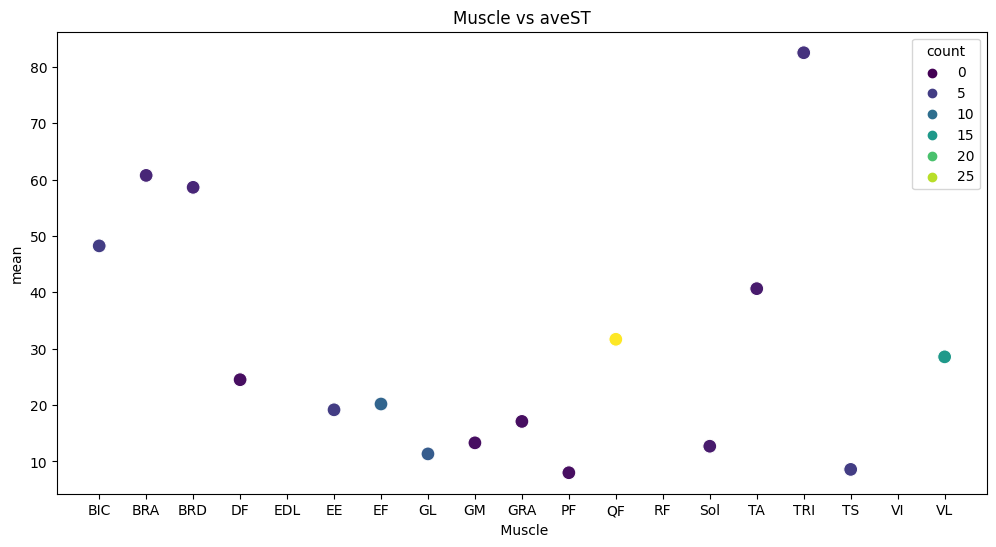

In [ ]:
# grouped_data = larger_df_cleaned.groupby([' Muscle'])['aveST (N/cm2)'].mean()
grouped_data = larger_df_cleaned.groupby(' Muscle')['aveST (N/cm2)'].agg(['mean', 'count']).reset_index()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=grouped_data, x=" Muscle", y="mean", hue="count", palette="viridis", s=100)
plt.title("Muscle vs aveST")
plt.show()

# grouped_data

In [ ]:
grouped_data

# Methods reduction and create plot data

In [ ]:
!pip install xlsxwriter
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd

data = {
    "Number of Subjects": ["Less than 5", "5 to 10", "More than 10", "", ""],
    "Muscle volume": ["CSA accumulation times slice interval", "Value from literature", "N/A", "", ""],
    "Fiber/Fascicle length": ["Value from literature", "CT scan", "MRI scan", "Ultrasound", "N/A"],
    "ASCA": ["Maximal value from MRI scan", "Value from MRI scan", "Value from literature", "", ""],
    "PSCA": ["Value from literature", "Muscle vol/Fiber length", "Muscle vol/(Fiber length*cos θ)", "Muscle vol*cos θ/Fiber length", "N/A"],
    "Torque": ["Highest value from torque meter (multiple MVC trials)", "Highest value from torque meter (MVC + e-stim trials)", "Value from literature", "", ""],
    "Movement Arm measured": ["Limb length", "Measured from CT", "Measured from MRI", "Value from literature", "N/A"],
    "Force": ["Torque/Moment Arm", "N/A", "", "", ""],
    "Tension": ["Force/ACSA", "Force/PCSA", "Limb Force/PCSA", "N/A", ""]
}
df = pd.DataFrame(data)
df.to_excel("meta_analysis_summary.xlsx", index=False)



In [ ]:
# @title Old way
import pandas as pd
Methods_df = pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='allData') # Extracted data for each study
Methods_df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows

#<----join columns
def concatenate_columns(row):
    return ' '.join([str(value) for value in row if not pd.isna(value)])

# Apply the custom function to create a new column
Methods_df['MA'] = Methods_df[['Moment Arm measured','Moment Arm correction']].apply(concatenate_columns, axis=1)
Methods_df['TQ'] = Methods_df[['Torque','Torque correction']].apply(concatenate_columns, axis=1)
Methods_df['lf'] = Methods_df[['Fiber/Fascicle length method','Fiber/Fascicle length']].apply(concatenate_columns, axis=1)
Methods_df['csa'] = Methods_df[['ASCA','PSCA']].apply(concatenate_columns, axis=1)
Methods_df['M_Vol'] = Methods_df['Muscle volume']
Methods_df['F'] = Methods_df['Force']
Methods_df['ST'] = Methods_df['Specific Tension']
Methods_df['a'] = Methods_df['Pennation angle']

# <--reduced data
def correct_MA(description):
  if pd.notna(description):
    # Replace "MRI MVC correction" with "MRI at rest, MVC & JA correction"
    description = description.replace("Measured from MRI MVC correction and Joint angle correction", "MRI at rest, MVC & JA correction")

    # Replace "MRI at rest Joint angle correction" with "MRI at rest JA correction"
    description = description.replace("MRI at rest Joint angle correction", "MRI at rest, JA correction")
    description = description.replace("Limb length None", "Limb length")
    description = description.replace("Ultrasound measured at MVC angle", "US at MVC JA")
    description = description.replace("MRI at rest MVC correction and Joint angle correction", "MRI at rest, MVC & JA correction")
    description = description.replace("Measured from MRI measured at MVC angle", "MRI at MVC JA")

    description = description.replace("Measured from MRI", "MRI at rest")
    description = description.replace("MRI at rest", "MRI at rest")
    description = description.replace("Measured from MRI None", "MRI at rest")
    description = description.replace("MRI at rest None", "MRI at rest")
    description = description.replace(" Literature value MVC + Cadaver shrinkinge", "Literature value at experimental JA, MVC & cadaver shrinkinge correction")
    description = description.replace(" Literature value", "Literature value at experimental JA")

    # Add any other replacements you need here

  return description


def correct_torque(description):
    if pd.notna(description):
       description = description.replace("Highest value from torque meter (multiple MVC trials) Activation", "max MVC + ITT, Activation correction")
       description = description.replace("Highest value from torque meter (MVC + e-stim trials) Activation & Coactivation", "max MVC + ITT, Activation & Coactivation correction")
       description = description.replace("Highest value from torque meter (multiple MVC trials)", "max MVC")
       description = description.replace("Highest value from torque meter (multiple MVC trials) None", "max MVC")
       description = description.replace("Highest value from torque meter (multiple MVC trials) coactivation", "max MVC, Coactivation correction")
       description = description.replace("Highest torque from stimulation coactivation", "max MVC from stimulation, Coactivation correction")
       description = description.replace("Highest value from torque meter (multiple MVC trials) compensate for gravity", "max MVC, Gravity correction")
       description = description.replace("Highest torque from stimulation", "max MVC from stimulation")

    return description

def correct_fiberlength(description):
    if pd.notna(description):
       description = description.replace("Ultrasound Fiber length at MVC", "US at MVC")
       description = description.replace("Ultrasound Fascicle length at MVC", "US at MVC")
       description = description.replace("MRI scan muscle length x k (lit ratio)", "MRI muscle length x literature ratio")
       description = description.replace("Ultrasound Fascicle length at rest", "US at rest")
       description = description.replace("Value from literature None", "Literature value")
       description = description.replace("Direct muscle length measured FWHM-optimal fiber length relationship from literature", "Directly measured muscle length & literature FWHM-optimal fiber length relationship")
    return description

def correct_volume(description):
    if pd.notna(description):
       description = description.replace("CSA accumulation times slice interval", "MRI, CSA x slice interval")
       description = description.replace("measured MRI ACSA and lit regression", "MRI, ACSA & literature regression relationship")
       description = description.replace("measured ACSA and lit regression", "MRI, ACSA & literature regression relationship")
       description = description.replace("3D photogrammetry approach", "3D photogrammetry reconstruction")
    return description


def correct_csa(description):
    if pd.notna(description):
       description = description.replace("Muscle vol*cos θ/Fiber length", "(Muscle vol/Fiber length)*cos(θ)")
       description = description.replace("Maximal value from MRI scan", "MRI, max ACSA")
       description = description.replace("CT scan ACSA +  MVC correction from literature  Literature value", "CT, literature MVC correction")
    return description

Methods_df['MA'] = Methods_df['MA'].apply(correct_MA)
Methods_df['TQ'] = Methods_df['TQ'].apply(correct_torque)
Methods_df['lf'] = Methods_df['lf'].apply(correct_fiberlength)
Methods_df['csa'] = Methods_df['csa'].apply(correct_csa)
Methods_df['M_Vol'] = Methods_df['M_Vol'].apply(correct_volume)

#<- write to file
cols=['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       ' Number of subjects, N', ' Muscle', 'Type', 'Gender', 'combined',
       'CSA', ' Miscellaneous',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', 'M_Vol','lf', 'a', 'csa','TQ','MA','F','ST',
       'Overall note']

Methods_df2=Methods_df[cols]
writer = pd.ExcelWriter('ST_review_ALLdata_Lomas2.xlsx', engine='xlsxwriter')
# Write each DataFrame to a different sheet
Methods_df2.to_excel(writer, sheet_name='reduced', index=False)
writer.save()


## new create- plot data, paper stats etc


In [ ]:
import pandas as pd
import re
Methods_df = pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='allData') # Extracted data for each study
# Methods_df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows
paperstats=pd.read_csv('Paperstats.csv')# has extracted country, study design

#<----join columns
def concatenate_columns(row):
    return ' '.join([str(value) for value in row if not pd.isna(value)])

# Apply the custom function to create a new column
Methods_df['MA'] = Methods_df[['Moment Arm measured','Moment Arm correction']].apply(concatenate_columns, axis=1)
Methods_df['TQ'] = Methods_df[['Torque','Torque correction']].apply(concatenate_columns, axis=1)
Methods_df['lf'] = Methods_df[['Fiber/Fascicle length method','Fiber/Fascicle length']].apply(concatenate_columns, axis=1)
Methods_df['csa'] = Methods_df[['ASCA','PSCA']].apply(concatenate_columns, axis=1)
Methods_df['M_Vol'] = Methods_df['Muscle volume']
Methods_df['F'] = Methods_df['Force']
Methods_df['ST'] = Methods_df['Specific Tension']
Methods_df['a'] = Methods_df['Pennation angle']



def printMissing(unique,replacements,variable):
  unreg=[text for text in unique if text not in replacements.keys()]
  print(variable + ' has missing:'+ str(unreg))


# replacementsMA = {
#             "Measured from MRI MVC correction and Joint angle correction": "MRI at rest, MVC & JA correction",
#             "MRI at rest Joint angle correction": "MRI at rest, JA correction",
#             "Limb length None": "Limb length",
#             "Ultrasound measured at MVC angle": "US at MVC JA",
#             "MRI at rest MVC correction and Joint angle correction": "MRI at rest, MVC & JA correction",
#             "Measured from MRI measured at MVC angle": "MRI at MVC JA",
#             "Measured from MRI": "MRI at rest",
#             "MRI at rest": "MRI at rest",
#             "Measured from MRI None": "MRI at rest",
#             "MRI at rest None": "MRI at rest",
#             " Literature value MVC + Cadaver shrinking": "Literature value at experimental JA, MVC & cadaver shrinkinge correction",
#             " Literature value": "Literature value at experimental JA"
#             # Add any other replacements you need here
#         }

# replacementsTorq = {
#             "Highest value from torque meter (multiple MVC trials) Activation": "max MVC + ITT, Activation correction",
#             "Highest value from torque meter (MVC + e-stim trials) Activation & Coactivation": "max MVC + ITT, Activation & Coactivation correction",
#             "Highest value from torque meter (multiple MVC trials)": "max MVC",
#             "Highest value from torque meter (multiple MVC trials) None": "max MVC",
#             "Highest value from torque meter (multiple MVC trials) coactivation": "max MVC, Coactivation correction",
#             "Highest torque from stimulation coactivation": "max MVC from stimulation, Coactivation correction",
#             "Highest value from torque meter (multiple MVC trials) compensate for gravity": "max MVC, Gravity correction",
#             "Highest torque from stimulation": "max MVC from stimulation"
#             # Add any other replacements you need here
#         }

# replacementslf={
#             "Ultrasound Fiber length at MVC": "US at MVC",
#             "Ultrasound Fascicle length at MVC of representative muscle":"US at MVC rep muscle",
#             "Ultrasound Fascicle length at MVC": "US at MVC",
#             "MRI scan muscle length x k (lit ratio)": "MRI muscle length x literature ratio",
#             "Ultrasound Fascicle length at rest": "US at rest",
#             "Value from literature None": "Literature value",
#             "Direct muscle length measured FWHM-optimal fiber length relationship from literature": "Directly measured muscle length & literature FWHM-optimal fiber length relationship",
#             "Value from literature": "Literature value",
#             "MRI scan muscle thickness measured at rest.": "MRI at rest"
#             # Add any other replacements you need here
#         }
# replacementsVol={
#             "CSA accumulation times slice interval": "MRI, CSA x slice interval",
#             "measured MRI ACSA and lit regression": "MRI, ACSA & literature regression relationship",
#             "measured ACSA and lit regression": "MRI, ACSA & literature regression relationship",
#             "3D photogrammetry approach": "3D photogrammetry reconstruction",
#             "Ultrasound, ACSA at 50% and literature regression": "US, ACSA & literature regression relationship"
#             # Add any other replacements you need here
#         }

# replacementsCSA={
#             "Muscle vol*cos θ/Fiber length": "(Muscle vol/Fiber length)*cos(θ)",
#             "Maximal value from MRI scan": "MRI, max ACSA",
#             "CT scan ACSA +  MVC correction from literature  Literature value": "CT, literature MVC correction"

#             # Add any other replacements you need here
#         }



uniqueMA=Methods_df['MA'].unique()
uniqueTQ=Methods_df['TQ'].unique()
uniquelf=Methods_df['lf'].unique()
uniqueVol=Methods_df['M_Vol'].unique()
uniqueCSA=Methods_df['csa'].unique()

#---map changes
# printMissing(uniqueMA,replacementsMA,'MA')
# Methods_df['MA']=Methods_df['MA'].map(replacementsMA)

# printMissing(uniqueTQ,replacementsTorq,'Torq')
# Methods_df['TQ']=Methods_df['TQ'].map(replacementsTorq)

# printMissing(uniquelf,replacementslf,'lf')
# Methods_df['lf']=Methods_df['lf'].map(replacementslf)

# printMissing(uniqueVol,replacementsVol,'Vol')
# Methods_df['M_Vol']=Methods_df['M_Vol'].map(replacementsVol)

# printMissing(uniqueCSA,replacementsCSA,'CSA')
# Methods_df['csa']=Methods_df['csa'].map(replacementsCSA)


#---new apply
replacementsMethods = {
    #replacementsMA
            "Measured from MRI MVC correction and Joint angle correction": "MRI at rest, MVC & JA correction",
            "MRI at rest Joint angle correction": "MRI at rest, JA correction",
            "Limb length None": "Limb length",
            "Ultrasound measured at MVC angle": "US at MVC JA",
            "MRI at rest MVC correction and Joint angle correction": "MRI at rest, MVC & JA correction",
            "Measured from MRI measured at MVC angle": "MRI at MVC JA",
            "Measured from MRI": "MRI at rest",
            "MRI at rest": "MRI at rest",
            "Measured from MRI None": "MRI at rest",
            "MRI at rest None": "MRI at rest",
            " Literature value MVC + Cadaver shrinking": "Literature value at experimental JA, MVC & cadaver shrinkinge correction",
            " Literature value": "Literature value at experimental JA",
            "Measured from Xray, at optimal JA": "Xray at MVC JA",
            # Add any other replacements you need here


#replacementsTorq
            "Highest value from torque meter (multiple MVC trials) Activation": "max MVC + ITT, Activation correction",
            "Highest value from torque meter (MVC + e-stim trials) Activation & Coactivation": "max MVC + ITT, Activation & Coactivation correction",
            "Highest value from torque meter (multiple MVC trials)": "max MVC",
            "Highest value from torque meter (multiple MVC trials) None": "max MVC",
            "Highest value from torque meter (multiple MVC trials) coactivation": "max MVC, Coactivation correction",
            "Highest torque from stimulation coactivation": "max MVC from stimulation, Coactivation correction",
            "Highest value from torque meter (multiple MVC trials) compensate for gravity": "max MVC, Gravity correction",
            "Highest torque from stimulation": "max MVC from stimulation",
            # Add any other replacements you need here


#replacementslf
            "Ultrasound Fiber length at MVC": "US at MVC",
            "Ultrasound Fascicle length at MVC of representative muscle":"US at MVC rep muscle",
            "Ultrasound Fascicle length at MVC": "US at MVC",
            "MRI scan muscle length x k (lit ratio)": "MRI muscle length x literature ratio",
            "Ultrasound Fascicle length at rest": "US at rest",
            "Value from literature None": "Literature value",
            "Direct muscle length measured FWHM-optimal fiber length relationship from literature": "Directly measured muscle length & literature FWHM-optimal fiber length relationship",
            "Value from literature": "Literature value",
            "MRI scan muscle thickness measured at rest.": "MRI at rest",
            # Add any other replacements you need here

#replacementsVol
            "CSA accumulation times slice interval": "MRI, CSA x slice interval",
            "measured MRI ACSA and lit regression": "MRI, ACSA & literature regression relationship",
            "measured ACSA and lit regression": "MRI, ACSA & literature regression relationship",
            "3D photogrammetry approach": "3D photogrammetry reconstruction",
            "Ultrasound, ACSA at 50% and literature regression": "US, ACSA & literature regression relationship",
            # Add any other replacements you need here


#replacementsCSA
            "Muscle vol*cos θ/Fiber length": "(Muscle vol/Fiber length)*cos(θ)",
            "Maximal value from MRI scan": "MRI, max ACSA",
            "CT scan ACSA +  MVC correction from literature  Literature value": "CT ACSA, literature MVC correction",
            "CT scan ACSA +  MVC correction from literature":"CT ACSA, literature MVC correction",
            "CT scan":"CT ACSA",
            # Add any other replacements you need here
        }

def handle_missing(text):
    if text not in replacementsMethods:
        print(text)
        return text  # Return the original text if not found in replacements
    else:
        return replacementsMethods[text]



#---map changes
# printMissing(uniqueMA,replacementsMA,'MA')
Methods_df['MA']=Methods_df['MA'].apply(handle_missing)

# printMissing(uniqueTQ,replacementsTorq,'Torq')
Methods_df['TQ']=Methods_df['TQ'].apply(handle_missing)

# printMissing(uniquelf,replacementslf,'lf')
Methods_df['lf']=Methods_df['lf'].apply(handle_missing)

# printMissing(uniqueVol,replacementsVol,'Vol')
Methods_df['M_Vol']=Methods_df['M_Vol'].apply(handle_missing)

# printMissing(uniqueCSA,replacementsCSA,'CSA')
Methods_df['csa']=Methods_df['csa'].apply(handle_missing)


#<- write to file
cols=['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       ' Number of subjects, N', ' Muscle', 'Type', 'Gender',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', 'M_Vol','lf', 'a','CSA', 'csa','TQ','MA','F','ST',
       'Overall note',' Miscellaneous','Total Score']
Methods_df2=Methods_df[cols]

#rename
column_name_changes = {'M_Vol': 'Muscle volume method',
                       'lf': 'Fascicle length method',
                       'a':'Pennation angle method',
                       'csa': 'PCSA method',
                       'TQ':'Torque method',
                       'MA':'Moment arm method',
                       'F': 'Force method',
                       'ST':'Specific Tension method',
                       ' Voluntary (V) or Stimulated (S) Force measurement':'Voluntary (V) or Stimulated (S)',
                       'Total Score':'Score'}

# Use the rename() method to rename the columns
Methods_df2 = Methods_df2.rename(columns=column_name_changes)

#correct V or S
correctVS={
            "max MVC + ITT, Activation correction": "V",
            "max MVC + ITT, Activation & Coactivation correction": "V",
            "max MVC, Coactivation correction": "V",
            "max MVC from stimulation, Coactivation correction": "S",
            "max MVC, Gravity correction": "V",
            "max MVC": "V",
            "max MVC from stimulation":"S"
            # Add any other replacements you need here
        }

Methods_df2['Voluntary (V) or Stimulated (S)']=Methods_df2['Torque method'].map(correctVS)


#<--------------------add scoring to data-------------------------------------->

def applyScoring(Methods_df):
  methods_scores_df = pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='score')
  scoring_scheme = dict(zip(methods_scores_df['Method'], methods_scores_df['Score']))
  cols=['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method',
                'Force method','Specific Tension method']
  Methods_df_r=Methods_df[cols]
  # Function to calculate the score for a row
  def calculate_score(row):
      score = 0
      for column in Methods_df_r.columns:
          method = row[column]
          score += scoring_scheme.get(method, 0)
      return score

  Methods_df['Score'] = Methods_df_r.apply(calculate_score, axis=1)
  return Methods_df

# Methods_df2=applyScoring(Methods_df2)


def processAgeandTraining(grouped_data):
    def categorize_age(age):
      if age < 18:
          return f'CHD'  # Add 'YNG' if age is below 30
      elif age < 35:
          return f'YNG'  # Add 'YNG' if age is below 30
      elif age < 65:
          return f'MID'  # Add 'MID' if age is between 30 and 49
      else:
          return f'OLD'  # Add 'OLD' if age is 50 or above

    def categorize_training(text):
      # text_lower = text.lower()
      text_lower = text
      # print(text_lower)
      if re.search(r'\bUT\b', text_lower) or re.search(r'\bUT Exp\b', text_lower) or re.search(r'\bUT Control\b', text_lower) or re.search(r'\bT Control\b', text_lower):
          return 'Untrained'
      elif re.search(r'\bT\b', text_lower) or re.search(r'\bT Exp\b', text_lower):
          return 'Trained'
      else:
          return 'Normal'

    grouped_data['Age type']=grouped_data['aveAge (years)'].map(categorize_age)
    grouped_data['Training type']=grouped_data['Type'].map(categorize_training)
    return grouped_data

Methods_df2=processAgeandTraining(Methods_df2)

In [ ]:
from openpyxl import load_workbook
import pandas as pd
import shutil


def add_or_update_sheets(input_file, sheet_dataframes):
    # Copy the original file to avoid modifying it directly
    output_file = input_file[:-5] + '_processed.xlsx'
    shutil.copy(input_file, output_file)

    # Load the existing workbook
    workbook = load_workbook(output_file)
    writer = pd.ExcelWriter(output_file, engine='openpyxl')
    writer.book = workbook

    for sheet_name, df in sheet_dataframes.items():
        if sheet_name in writer.book.sheetnames:
            # Delete the existing sheet to update data
            idx = writer.book.sheetnames.index(sheet_name)
            writer.book.remove(writer.book.worksheets[idx])
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    # Save the changes to the new workbook
    writer.save()


# def add_or_update_and_save_as_csv(input_file, sheet_dataframes):
#     # Copy the original file to avoid modifying it directly
#     output_file = input_file[:-5] + '_processed.xlsx'
#     shutil.copy(input_file, output_file)

#     # Load the existing workbook
#     workbook = load_workbook(output_file)
#     writer = pd.ExcelWriter(output_file, engine='openpyxl')
#     writer.book = workbook

#     # Create a dictionary to store all dataframes
#     all_dataframes = {}

#     for sheet_name, df in sheet_dataframes.items():
#         if sheet_name in writer.book.sheetnames:
#             # Delete the existing sheet to update data
#             idx = writer.book.sheetnames.index(sheet_name)
#             writer.book.remove(writer.book.worksheets[idx])
#         df.to_excel(writer, sheet_name=sheet_name, index=False)

#         # Store dataframes in the dictionary
#         all_dataframes[sheet_name] = df

#     # Save the changes to the new workbook
#     writer.save()

#     # Combine all dataframes into one
#     combined_df = pd.concat(all_dataframes.values(), axis=0)

#     # Save the combined dataframe as a single CSV file
#     combined_csv_output_file = output_file = input_file[:-5] + '_processed.csv'
#     combined_df.to_csv(combined_csv_output_file, index=False)



#df created using site https://tableconvert.com/excel-to-json
muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris","fast/slow":"60/40","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Upper leg"},{"Muscle":"PF","name":"Plantar Flexors","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"GL","name":"Gastrocnemius Lateralis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"BIC","name":"Biceps Brachii","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRA","name":"Brachialis","fast/slow":"Fast","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRD","name":"Brachioradialis","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EF","name":"Elbow Flexors","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EE","name":"Elbow Extendors","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"TS","name":"Triceps Surae","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"VM","name":"Vastus Medialis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Upper leg"},{"Muscle":"VI","name":"Vastus Intermedius","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Upper leg"},{"Muscle":"VL","name":"Vastus Lateralis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Upper leg"},{"Muscle":"RF","name":"Rectus Femoris","fast/slow":"60/40","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Upper leg"},{"Muscle":"TRI","name":"Triceps Brachii","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"Sol","name":"Soleus","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"TA","name":"Tibialis Anterior","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GM","name":"Gastrocnemius Medialis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"DF","name":"Dorsiflexor","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GRA","name":"Gracilis","fast/slow":"Slow","Joint type":"biarticular","antigrav/grav":"non-antigravity","Joint action":"hip adductor","secondary joint action":" knee flexor","anatomical location":"Upper leg"}]
# Create a DataFrame from the list of dictionaries
muscle_grp_df = pd.DataFrame(muscle_grp)
final_plotdata= pd.merge(Methods_df2, muscle_grp_df, left_on=' Muscle', right_on='Muscle', how='left')

final_plotdata.to_csv('Plotdata.csv', index=False)
# writer = pd.ExcelWriter('Plotdata.xlsx', engine='xlsxwriter')
# final_plotdata.to_excel(writer, sheet_name='Plotdata', index=False)
# writer.save()

#now drop extra to creat 'reduced data'
Methods_df3=Methods_df2
Methods_df3.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows

sheet_data = {
    'Plotdata': final_plotdata,
    'ReducedData': Methods_df3,
    'Paperstats':paperstats
}


# Call the function with the file path and the dictionary of sheet names and DataFrames- Saved as XLSX
add_or_update_sheets('ST_review_ALLdata_Lomas.xlsx', sheet_data)

# Saved as csv
# add_or_update_and_save_as_csv('ST_review_ALLdata_Lomas.xlsx', sheet_data)



In [ ]:
#df created using site https://tableconvert.com/excel-to-json
# muscle_grp=[{"Muscle":"QF","name":"Quadriceps Femoris","fast/slow":"60/40","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"PF","name":"Plantar Flexors","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"GL","name":"Gastrocnemius Lateralis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"BIC","name":"Biceps Brachii","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRA","name":"Brachialis","fast/slow":"Fast","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"BRD","name":"Brachioradialis","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EF","name":"Elbow Flexors","fast/slow":"50/50","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow flexor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"EE","name":"Elbow Extendors","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"TS","name":"Triceps Surae","fast/slow":"Slow","Joint type":"mixed","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"VM","name":"Vastus Medialis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VI","name":"Vastus Intermedius","fast/slow":"60/40","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"VL","name":"Vastus Lateralis","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"","anatomical location":"Thigh"},{"Muscle":"RF","name":"Rectus Femoris","fast/slow":"60/40","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"knee extensor","secondary joint action":"hip flexor","anatomical location":"Thigh"},{"Muscle":"TRI","name":"Triceps Brachii","fast/slow":"Fast","Joint type":"mixed","antigrav/grav":"non-antigravity","Joint action":"elbow extensor","secondary joint action":"","anatomical location":"Upper arm"},{"Muscle":"Sol","name":"Soleus","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"TA","name":"Tibialis Anterior","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GM","name":"Gastrocnemius Medialis","fast/slow":"50/50","Joint type":"biarticular","antigrav/grav":"antigravity","Joint action":"ankle plantar flexor","secondary joint action":"knee flexor","anatomical location":"Lower leg"},{"Muscle":"DF","name":"Dorsiflexor","fast/slow":"Slow","Joint type":"monoarticular","antigrav/grav":"non-antigravity","Joint action":"ankle dorsiflexor","secondary joint action":"","anatomical location":"Lower leg"},{"Muscle":"GRA","name":"Gracilis","fast/slow":"Slow","Joint type":"biarticular","antigrav/grav":"non-antigravity","Joint action":"hip adductor","secondary joint action":" knee flexor","anatomical location":"Lower leg"}]
# # Create a DataFrame from the list of dictionaries
# muscle_grp_df = pd.DataFrame(muscle_grp)
# final_plotdata= pd.merge(Methods_df2, muscle_grp_df, left_on=' Muscle', right_on='Muscle', how='left')

# writer = pd.ExcelWriter('Plotdata.xlsx', engine='xlsxwriter')
# final_plotdata.to_excel(writer, sheet_name='Plotdata', index=False)
# writer.save()


# final_plotdata.to_csv('Plotdata.csv', index=False)



# writer = pd.ExcelWriter('ReducedData.xlsx', engine='xlsxwriter')
# # Write each DataFrame to a different sheet
# Methods_df2.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows
# Methods_df2.to_excel(writer, sheet_name='reduced', index=False)
# writer.save()

In [ ]:
Methods_df2.columns

In [ ]:
from tabulate import tabulate
# Convert the DataFrame to a table format
table = tabulate(Methods_df2, headers='keys', tablefmt='pretty', showindex=False)
# Print the formatted table
print(table)

## Scoring

## Old scoring

In [ ]:
#@title  Old scoring
# Methods_df2['Torque method'].unique()
import pandas as pd
from tabulate import tabulate

methods_scores_df = pd.read_excel('ST_review_ALLdata_Lomas_processed.xlsx',sheet_name='score')
scoring_scheme = dict(zip(methods_scores_df['Method'], methods_scores_df['Score']))
paperstats=pd.read_csv('Paperstats.csv')# has extracted country, study design

# Methods_df = pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='ReducedData') # Extracted data for each study
# Methods_df = pd.read_excel('ReducedData.xlsx',sheet_name='reduced') # Extracted data for each study
Methods_df = pd.read_excel('ST_review_ALLdata_Lomas_processed.xlsx',sheet_name='Plotdata') # Extracted data for each study
Methods_df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows
Methods_df = Methods_df[~((Methods_df['CovidenceID'].isin([2837, 2995])) & (Methods_df['CSA'] == 'ACSA'))]


cols=['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'Moment arm method','Force method','PCSA method']
Methods_df_r=Methods_df[cols]
# Function to calculate the score for a row
def calculate_score(row):
    score = 0
    for column in Methods_df_r.columns:
        method = row[column]
        score += scoring_scheme.get(method, 0)
    return score

Methods_df['newScore'] = Methods_df_r.apply(calculate_score, axis=1)




# Convert the DataFrame to a table format

paperstats_r=paperstats[['Covidence #', 'Study ID', 'Title_y','Country', 'Study design', 'Authors', 'Year', 'Journal']].drop_duplicates()
mergedDF= pd.merge(Methods_df, paperstats_r, left_on='CovidenceID', right_on='Covidence #', how='left')

mergedDF.to_csv('Plotdata_scored.csv', index=False)

In [ ]:

# table = tabulate(mergedDF, headers='keys', tablefmt='pretty', showindex=False)
# # Print the formatted table
# print(table)

scoring_scheme



def create_score_df(df):
  df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows
  cols=['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'Moment arm method','Force method','PCSA method']
  # Methods_df_r=df[cols]

  for column in cols:
    df[column + '_score']=df[column].map(scoring_scheme)
  return df
# Methods_df['Muscle volume method'].map(scoring_scheme)

new_df=create_score_df(Methods_df)

In [ ]:
table = tabulate(new_df, headers='keys', tablefmt='pretty', showindex=False)
# Print the formatted table
print(new_df)

In [ ]:
new_df_r=new_df[['CovidenceID',' Muscle','Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'Moment arm method','Force method','PCSA method','newScore', 'Muscle volume method_score', 'Torque method_score','Fascicle length method_score', 'Pennation angle method_score','Moment arm method_score', 'Force method_score', 'PCSA method_score']]


new_df_r.to_csv('Check_method_scoring.csv', index=False)


In [ ]:
# table = tabulate(new_df, headers='keys', tablefmt='pretty', showindex=False)
# # Print the formatted table
# print(table)
new_df.columns

In [ ]:
writer = pd.ExcelWriter('Scores.xlsx', engine='xlsxwriter')
# Write each DataFrame to a different sheet
Methods_df.to_excel(writer, index=False)
writer.save()

## new Scoring

In [ ]:
#@title load data
#Load data
import pandas as pd
from tabulate import tabulate
import numpy as np
import random

def concatenate_columns(row):
    return ' '.join([str(value) for value in row if not pd.isna(value)])


def loadData():
  df = pd.read_excel('ST_review_ALLdata_Lomas_processed.xlsx',sheet_name='Plotdata') # Extracted data for each study
  df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows
  df = df[~((df['CovidenceID'].isin([2837, 2995])) & (df['CSA'] == 'ACSA'))]

  column_names = ['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Force method','Specific Tension method']
  for column_name in column_names:
    df[column_name] = df[column_name].fillna('none')
    # Apply the custom function to create a new column
    df['Torque-Force method'] = df[['Torque method','Force method']].apply(concatenate_columns, axis=1)
  return df
Methods_df=loadData()



In [ ]:
Methods_df

,CovidenceID,aveAge (years),aveHeight (cm),aveWeight (kg),"Number of subjects, N",Muscle,Type,Gender,Voluntary (V) or Stimulated (S),aveVol (cm3),...,anatomical location,Torque-Force method,Torque-Force method_score,Moment arm method_score,Muscle volume method_score,Fascicle length method_score,Pennation angle method_score,PCSA method_score,Specific Tension method_score,newScore
0,4162,23.0,176.0,70.6,16,QF,YNG,M,V,NaN,...,Thigh,"max MVC + ITT, Activation correction Tendon Fo...",10,2,4,4,1,0,0,21
1,4162,22.0,167.0,61.2,15,QF,YNG,F,V,NaN,...,Thigh,"max MVC + ITT, Activation correction Tendon Fo...",10,2,4,4,1,0,0,21
2,4162,72.0,174.0,78.9,20,QF,OLD,M,V,NaN,...,Thigh,"max MVC + ITT, Activation correction Tendon Fo...",10,2,4,4,1,0,0,21
3,4162,71.0,160.0,67.3,20,QF,OLD,F,V,NaN,...,Thigh,"max MVC + ITT, Activation correction Tendon Fo...",10,2,4,4,1,0,0,21
5,4135,72.7,169.3,78.4,11,GL,OLD UT EXP,M,V,132.9,...,Lower leg,"max MVC + ITT, Activation & Coactivation corre...",9,2,4,4,2,0,0,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2899,28.0,184.0,84.0,6,EF,YNG Control,M,V,NaN,...,Upper arm,"max MVC Tendon force, % contribution from lite...",4,0,0,0,0,8,0,12
140,2899,68.0,176.0,78.0,7,EF,OLD Control,M,V,NaN,...,Upper arm,"max MVC Tendon force, % contribution from lite...",4,0,0,0,0,8,0,12
141,2899,69.0,171.0,74.0,6,EF,OLD T swim,M,V,NaN,...,Upper arm,"max MVC Tendon force, % contribution from lite...",4,0,0,0,0,8,0,12
142,2899,70.0,177.0,73.0,5,EF,OLD T run,M,V,NaN,...,Upper arm,"max MVC Tendon force, % contribution from lite...",4,0,0,0,0,8,0,12


### Look  at each method and grouped studies

In [ ]:
# Methods_df['Torque-Force method'].unique()

Methods_df['CovidenceID']

In [ ]:

chosen='max MVC External Force (Limb Force)'
Methods_df[Methods_df['Torque-Force method']==chosen]



In [ ]:
# Get unique values for the 'Group' column
# chosen_grp='Torque-Force method'
chosen_grp='PCSA method'


unique_groups = Methods_df[chosen_grp].unique()

# Dictionary to store unique ID for each group
# unique_ids_per_group = {}
# # Iterate over unique groups
# for group in unique_groups:
#     # Filter DataFrame for each group
#     group_data = Methods_df[Methods_df['Torque-Force method'] == group]
#     # Get unique ID for the group
#     unique_id = group_data['CovidenceID'].unique()
#     # Store unique ID in the dictionary
#     unique_ids_per_group[group] = unique_id

# # Print unique IDs for each group
# for group, unique_id in unique_ids_per_group.items():
#     print(f"Group {group}: Unique ID(s) - {unique_id}")


# List to store data for the table
table_data = []

# Iterate over unique groups
for group in unique_groups:
    # Filter DataFrame for each group
    group_data = Methods_df[Methods_df[chosen_grp] == group]
    # Get unique ID for the group
    unique_id = group_data['CovidenceID'].unique()
    # Append data to the table_data list
    table_data.append({chosen_grp: group, 'CovidenceID': unique_id})

# Create DataFrame from table_data
result_df = pd.DataFrame(table_data)

# Display the result DataFrame
result_df


In [ ]:
result_df.to_excel('Torque_force_methods.xlsx', index=False)

In [ ]:
table = tabulate(new_df, headers='keys', tablefmt='pretty', showindex=False)
# Print the formatted table
print(table)

In [ ]:
#@title Create new Score table if methods entries change
import pandas as pd
from tabulate import tabulate
import numpy as np
import random



def assignScore(df,column_names):
  new_df = pd.DataFrame()  # Create an empty DataFrame to store the results

  for column_name in column_names:
    methods=df[column_name].unique()
    scores=[0]* len(methods)
    scoreCol=column_name+' Score'
    # Create a DataFrame
    data = {column_name: methods, scoreCol: scores}
    print(data)
    method_df = pd.DataFrame(data)

    # Append the data to the new DataFrame
    new_df = pd.concat([new_df, method_df], axis=1)

  return new_df


def assignScoreV2(df, column_names):
    new_df = pd.DataFrame()  # Create an empty DataFrame to store the results

    for column_name in column_names:
        methods = df[column_name].unique()
        scores = [random.uniform(0, 10) for _ in range(len(methods))]  # Assign random scores

        scoreCol = column_name + ' Score'

        # Create a DataFrame for the current column
        data = {column_name: methods, scoreCol: scores}
        method_df = pd.DataFrame(data)

        # Append the data to the new DataFrame
        if new_df.empty:
            new_df = method_df
        else:
            new_df = new_df.merge(method_df, on=column_name, how='outer')

    return new_df  # Return the new DataFrame

# List of column names for the methods
# column_names = ['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Force method','Specific Tension method']
column_names = ['Muscle volume method', 'Torque-Force method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Specific Tension method']
# column_names = ['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Force method','Specific Tension method']

result_df =assignScore(Methods_df,column_names)
# Convert the DataFrame to a table format
table = tabulate(result_df, headers='keys', tablefmt='pretty', showindex=False)

# Print the formatted table
print(table)

result_df.to_excel('Scoring.xlsx', index=False)




In [ ]:
#@title use new scoring scheme- Old. errors with repeated

# def createScoringScheme(methods_scores_df):
#   scoring_scheme = dict(zip(methods_scores_df['Method'], methods_scores_df['Score']))
#   return scoring_scheme

# TF_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='Torque-Force'))
# MA_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='MA'))
# MV_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='MV'))
# fl_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='fl'))
# Pa_scoring_scheme =createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='Pa'))
# pcsa_scoring_scheme =createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='pcsa'))
# ST_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='ST'))

# allScore=[]
# allScore.append(TF_scoring_scheme)
# allScore.append(MA_scoring_scheme)
# allScore.append(MV_scoring_scheme)
# allScore.append(fl_scoring_scheme)

# #combine all into one
# # TF_scoring_scheme.update(MA_scoring_scheme)
# # TF_scoring_scheme.update(MV_scoring_scheme)
# # TF_scoring_scheme.update(fl_scoring_scheme)
# # TF_scoring_scheme.update(Pa_scoring_scheme)
# # TF_scoring_scheme.update(pcsa_scoring_scheme)
# # TF_scoring_scheme.update(ST_scoring_scheme)


# column_names = ['Muscle volume method', 'Torque-Force method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Specific Tension method']

# def create_score_df(df):
#   # cols=['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'Moment arm method','Force method','PCSA method']
#   cols = ['Muscle volume method', 'Torque-Force method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Specific Tension method']
#   for column in cols:
#     df[column + '_score']=df[column].map(TF_scoring_scheme)
#   return df
# new_df=create_score_df(Methods_df)

# Methods_df_r=Methods_df[column_names]
# # Function to calculate the score for a row
# def calculate_score(row):
#     score = 0
#     for column in Methods_df_r.columns:
#         method = row[column]
#         score += TF_scoring_scheme.get(method, 0)
#     return score

# new_df['newScore'] = Methods_df_r.apply(calculate_score, axis=1)



In [ ]:
#@title Use plotdata to score

import pandas as pd
Methods_df=pd.read_csv('Plotdata_scored.csv')

In [ ]:
Methods_df


In [ ]:
#@title use new scoring scheme
def createScoringScheme(methods_scores_df):
  scoring_scheme = dict(zip(methods_scores_df['Method'], methods_scores_df['Score']))
  return scoring_scheme

TF_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='Torque-Force'))
MA_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='MA'))
MV_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='MV'))
fl_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='fl'))
Pa_scoring_scheme =createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='Pa'))
pcsa_scoring_scheme =createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='pcsa'))
ST_scoring_scheme = createScoringScheme(pd.read_excel('New_Scoring.xlsx',sheet_name='ST'))


allScore=[]
allScore.append(TF_scoring_scheme)
allScore.append(MA_scoring_scheme)
allScore.append(MV_scoring_scheme)
allScore.append(fl_scoring_scheme)
allScore.append(Pa_scoring_scheme)
allScore.append(pcsa_scoring_scheme)
allScore.append(ST_scoring_scheme)

column_names = [ 'Torque-Force method', 'Moment arm method','Muscle volume method','Fascicle length method', 'Pennation angle method', 'PCSA method','Specific Tension method']


def create_score_dfV2(df):
  # cols=['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'Moment arm method','Force method','PCSA method']
  cols = [ 'Torque-Force method', 'Moment arm method','Muscle volume method','Fascicle length method', 'Pennation angle method', 'PCSA method','Specific Tension method']
  for i,column in enumerate(cols):
    df[column + '_score']=df[column].map(allScore[i])
  return df


new_df=create_score_dfV2(Methods_df)

Methods_df_r=Methods_df[column_names]
# Function to calculate the score for a row
def calculate_score(row):
    score = 0
    for i,column in enumerate(Methods_df_r.columns):
        method = row[column]
        score += allScore[i].get(method, 0)
    return score

new_df['newScore'] = Methods_df_r.apply(calculate_score, axis=1)


In [ ]:
# new_df.to_excel("Plotdata_scored.xlsx", index=False)

new_df.to_csv('Plotdata_scored_updated.csv', index=False)

In [ ]:
paperstats=pd.read_csv('Paperstats.csv')# has extracted country, study design
paperstats_r=paperstats[['Covidence #', 'Study ID', 'Title_y','Country', 'Study design', 'Authors', 'Year', 'Journal']].drop_duplicates()
mergedDF= pd.merge(new_df, paperstats_r, left_on='CovidenceID', right_on='Covidence #', how='left')
# mergedDF.to_csv('Plotdata_scored.csv', index=False)
mergedDF.to_excel("Plotdata_scored.xlsx", index=False)

In [ ]:
table = tabulate(new_df, headers='keys', tablefmt='pretty', showindex=False)
# Print the formatted table
print(table)




In [ ]:
TF_scoring_scheme

#Create Methods df

In [ ]:
import pandas as pd
from tabulate import tabulate

methods_table = pd.read_excel('/content/Methods_table.xlsx',sheet_name='Methods_table') # created in R
# methods_table = pd.read_csv('/content/Methods_table.csv') # created in R

methods_table['mv_method'] = methods_table['mv_method'].replace({'none': 'mv_none'})
methods_table['f_method'] = methods_table['f_method'].replace({'none': 'f_none'})
methods_table['fl_method'] = methods_table['fl_method'].replace({'none': 'fl_none','Literature value':'fl Literature value'})
methods_table['pa_method'] = methods_table['pa_method'].replace({'none': 'pa_none','Literature value':'Pa Literature value'})
methods_table['t_method'] = methods_table['t_method'].replace({'none': 't_none'})
methods_table['pcsa_method'] = methods_table['pcsa_method'].replace({'none': 'pcsa_none'})
methods_table['ma_method'] = methods_table['ma_method'].replace({'none': 'ma_none'})



def createScoringScheme(methods_scores_df):
  scoring_scheme = dict(zip(methods_scores_df['Method'], methods_scores_df['Score']))
  return scoring_scheme

T_scoring_scheme_methods = createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='Torque'))
F_scoring_scheme_methods = createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='Force'))
MA_scoring_scheme_methods = createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='MA'))
MV_scoring_scheme_methods = createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='MV'))
fl_scoring_scheme_methods = createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='fl'))
Pa_scoring_scheme_methods =createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='Pa'))
pcsa_scoring_scheme_methods =createScoringScheme(pd.read_excel('/content/Methods mapping.xlsx',sheet_name='pcsa'))

methods_allScore=[]
methods_allScore.append(T_scoring_scheme_methods)
methods_allScore.append(F_scoring_scheme_methods)
methods_allScore.append(MA_scoring_scheme_methods)
methods_allScore.append(MV_scoring_scheme_methods)
methods_allScore.append(fl_scoring_scheme_methods)
methods_allScore.append(Pa_scoring_scheme_methods)
methods_allScore.append(pcsa_scoring_scheme_methods)



In [ ]:
#load to create new scoring without torque-force joined
# def loadData():
#   df =pd.read_csv('Plotdata.csv')
#   # df = pd.read_excel('ST_review_ALLdata_Lomas_processed.xlsx',sheet_name='Plotdata') # Extracted data for each study
#   df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows
#   df = df[~((df['CovidenceID'].isin([2837, 2995])) & (df['CSA'] == 'ACSA'))]

#   column_names = ['Muscle volume method', 'Torque method', 'Fascicle length method', 'Pennation angle method', 'PCSA method', 'Moment arm method','Force method','Specific Tension method']
#   for column_name in column_names:
#     df[column_name] = df[column_name].fillna('none')
#   return df
# Methods_df=loadData()

In [ ]:
table = tabulate(methods_table, headers='keys', tablefmt='pretty', showindex=False)
# Print the formatted table
print(table)

+------------+-------------+----------------------+------+----------+--------+----+--------+--------------+---------+-------------------------+--------+------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+-----------+----------+--------+------------------------------------------------+-------------------------------------------------------------------------------------+-----------------------------------+-----------------------------------------------------+--------------------------------------------------------------------------+-------------------------------------+---------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# methods_table.columns

methods_table['pcsa_method'].unique()

array(['(Muscle vol/Fiber length)*cos(ÃŽÂ¸)', 'MRI, max ACSA',
       'Muscle vol/Fiber length', 'CT ACSA, literature MVC correction',
       '(vol/muscle thickness)*sin(alpha)', 'CT ACSA'], dtype=object)

In [ ]:
methods_table

,Unnamed: 0,CovidenceID,StudyID,Year,newScore,aveAge,N,Muscle,trainingtype,agetype,...,aveST,mv_method,fl_method,pa_method,t_method,ma_method,pcsa_method,f_method,Calc,Assumptions
0,1,4162,McPhee 2018,2018,21,23.0,16,QF,Normal,YNG,...,29.000,"MRI, CSA x slice interval",US at MVC,Pa Literature value,"max MVC + ITT, Activation correction","MRI at rest, MVC & JA correction",(Muscle vol/Fiber length)*cos(ÃŽÂ¸),Tendon Force,_x000D__x000D_\nTo calculate specific tension ...,_x000D__x000D_\n_x000D__x000D_\nThe calculatio...
1,2,4135,Morse 2007,2007,21,72.7,11,GL,Untrained,OLD,...,8.900,"MRI, CSA x slice interval",US at MVC,Measured,"max MVC + ITT, Activation & Coactivation corre...",MRI at rest,(Muscle vol/Fiber length)*cos(ÃŽÂ¸),Tendon Force using relative PCSA,_x000D__x000D_\nTo calculate specific tension ...,The calculation of specific tension in this st...
2,3,4128,Marchetta 2012,2012,15,30.0,7,BIC,Normal,YNG,...,53.407,"MRI, CSA x slice interval",MRI muscle length x literature ratio,Pa Literature value,max MVC,"MRI at rest, JA correction",(Muscle vol/Fiber length)*cos(ÃŽÂ¸),Tendon Force using relative (PCSA x MA),_x000D__x000D_\n_x000D__x000D_\nTo calculate s...,_x000D__x000D_\n_x000D__x000D_\nThe study aims...
3,4,4128,Marchetta 2012,2012,15,30.0,7,BRA,Normal,YNG,...,56.510,"MRI, CSA x slice interval",MRI muscle length x literature ratio,Pa Literature value,max MVC,"MRI at rest, JA correction",(Muscle vol/Fiber length)*cos(ÃŽÂ¸),Tendon Force using relative (PCSA x MA),_x000D__x000D_\n_x000D__x000D_\nTo calculate s...,_x000D__x000D_\n_x000D__x000D_\nThe study aims...
4,5,4128,Marchetta 2012,2012,15,30.0,7,BRD,Normal,YNG,...,53.452,"MRI, CSA x slice interval",MRI muscle length x literature ratio,Pa Literature value,max MVC,"MRI at rest, JA correction",(Muscle vol/Fiber length)*cos(ÃŽÂ¸),Tendon Force using relative (PCSA x MA),_x000D__x000D_\n_x000D__x000D_\nTo calculate s...,_x000D__x000D_\n_x000D__x000D_\nThe study aims...
5,6,4127,Akagi 2009,2009,9,24.3,30,EF,Normal,YNG,...,14.700,mv_none,fl_none,pa_none,max MVC,Limb length,"MRI, max ACSA",External Force (Limb Force),_x000D__x000D_\nTo calculate the specific tens...,_x000D__x000D_\n_x000D__x000D_\nThe weakness i...
6,7,2995,Klein 2001,2001,16,22.6,20,EE,Normal,YNG,...,5.500,"MRI, CSA x slice interval",MRI muscle length x literature ratio,Pa Literature value,"max MVC + ITT, Activation & Coactivation corre...",ma_none,(Muscle vol/Fiber length)*cos(ÃŽÂ¸),External Force (Limb Force),_x000D__x000D_\nTo calculate specific tension ...,_x000D__x000D_\n_x000D__x000D_\nThe study ment...
7,8,2995,Klein 2001,2001,15,22.6,20,EF,Normal,YNG,...,16.500,"MRI, CSA x slice interval",MRI muscle length x literature ratio,pa_none,"max MVC + ITT, Activation & Coactivation corre...",ma_none,Muscle vol/Fiber length,External Force (Limb Force),_x000D__x000D_\nTo calculate specific tension ...,_x000D__x000D_\n_x000D__x000D_\nThe study ment...
8,9,2837,Bamman 2000,2000,12,36.0,32,TS,Untrained,MID,...,1.970,"MRI, CSA x slice interval",MRI muscle length x literature ratio,Pa Literature value,t_none,ma_none,(Muscle vol/Fiber length)*cos(ÃŽÂ¸),External Force (Limb Force),_x000D__x000D_\nTo calculate specific tension ...,_x000D__x000D_\n_x000D__x000D_\nThere is no we...
9,10,2833,Maden-Wilkinson 2020,2020,21,25.0,52,QF,Untrained,YNG,...,33.300,"MRI, CSA x slice interval",US at rest,Measured,"max MVC, Coactivation correction","MRI at rest, JA correction",(Muscle vol/Fiber length)*cos(ÃŽÂ¸),Tendon Force,_x000D__x000D_\nTo calculate specific tension ...,_x000D__x000D_\n_x000D__x000D_\nThere is no we...


In [ ]:
# Mapping dictionary for method descriptions
# method_mapping = {
#     'method1': 'Description of method 1.',
#     'method2': 'Description of method 2.',
#     # Add more entries as needed
# }


# method_mapping =TF_scoring_scheme


# Function to generate method description
def generate_method_description(row):
    descriptions = []
    methods = [ 't_method','f_method', 'ma_method','mv_method', 'fl_method', 'pa_method', 'pcsa_method']
    for i,method in enumerate(methods):
        if row[method] in methods_allScore[i]:
            # descriptions.append(method_mapping[row[method]])
            descriptions.append(f"• {methods_allScore[i][row[method]]}")
    return '\n'.join(descriptions)


# Create a new column in the DataFrame to store method descriptions
methods_table['method_descriptions'] = ''


# Iterate through each row of the DataFrame and generate method descriptions
for index, row in methods_table.iterrows():
    method_description = generate_method_description(row)
    print(f"Row {index + 1} method description:\n{method_description}\n")
    methods_table.at[index, 'method_descriptions'] = method_description





Row 1 method description:
• MVC torque measured using ITT to correct for muscle activation
• Tendon force= TQ/MA
• Moment arm measured (MRI) during rest and corrected using literature values to reflect MVC conditions and max. torque joint angle 
• Muscle volume estimated by summation of MRI axial images
• Fascicle length measured (US) during max. torque trial
• Pennation angle taken from literature
• PCSA= (Muscle vol/Fiber length)*cos(pennation angle)

Row 2 method description:
• MVC torque measured using ITT to correct for muscle activation and EMG to correct for antagonist activation
• Component tendon force calculated using relative PCSA
• Moment arm measured (MRI) during rest and not corresponding to max. torque joint angle
• Muscle volume estimated by summation of MRI axial images
• Fascicle length measured (US) during max. torque trial
• Pennation angle measured during max. torque trial
• PCSA= (Muscle vol/Fiber length)*cos(pennation angle)

Row 3 method description:
• MVC torqu

In [ ]:
import re

# Function to replace year with 'et al'
def replace_year_with_et_al(name):
    return re.sub(r'\s\d{4}$', ' et al.', name)

# Apply the function to the 'names' column
methods_table['StudyID'] = methods_table['StudyID'].apply(replace_year_with_et_al)


In [ ]:
wanted_cols=['CovidenceID','StudyID','Year','newScore','muscleName','method_descriptions','aveST']
methods_table_r=methods_table[wanted_cols]

In [ ]:
# methods_table.columns
methods_table_r

,CovidenceID,StudyID,Year,newScore,muscleName,method_descriptions,aveST
0,4162,McPhee et al.,2018,21,Quadriceps Femoris,• MVC torque measured using ITT to correct for...,29.000
1,4135,Morse et al.,2007,21,Gastrocnemius Lateralis,• MVC torque measured using ITT to correct for...,8.900
2,4128,Marchetta et al.,2012,15,Biceps Brachii,• MVC torque measured\n• Component tendon forc...,53.407
3,4128,Marchetta et al.,2012,15,Brachialis,• MVC torque measured\n• Component tendon forc...,56.510
4,4128,Marchetta et al.,2012,15,Brachioradialis,• MVC torque measured\n• Component tendon forc...,53.452
5,4127,Akagi et al.,2009,9,Elbow Flexors,• MVC torque measured\n• Tendon force approxim...,14.700
6,2995,Klein et al.,2001,16,Elbow Extensors,• MVC torque measured using ITT to correct for...,5.500
7,2995,Klein et al.,2001,15,Elbow Flexors,• MVC torque measured using ITT to correct for...,16.500
8,2837,Bamman et al.,2000,12,Triceps Surae,• Torque not used in calculation\n• Tendon for...,1.970
9,2833,Maden-Wilkinson et al.,2020,21,Quadriceps Femoris,• MVC torque measured with EMG to correct for ...,33.300


In [ ]:
import pandas as pd

# Convert integer values to strings
methods_table_r['CovidenceID'] = methods_table_r['CovidenceID'].astype(str)
methods_table_r['Year'] = methods_table_r['Year'].astype(str)
methods_table_r['newScore'] = methods_table_r['newScore'].astype(str)
methods_table_r['aveST'] = methods_table_r['aveST'].astype(str)

# Group by 'Group' column and concatenate values from 'Value1' and 'Value2'
result = methods_table_r.groupby('method_descriptions').agg({'CovidenceID': ' '.join, 'StudyID': ' '.join, 'Year': ' '.join, 'newScore': ' '.join, 'muscleName': ' '.join, 'aveST': ' '.join}).reset_index()

result


<ipython-input-34-1535f5d27643>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  methods_table_r['CovidenceID'] = methods_table_r['CovidenceID'].astype(str)
<ipython-input-34-1535f5d27643>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  methods_table_r['Year'] = methods_table_r['Year'].astype(str)
<ipython-input-34-1535f5d27643>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,method_descriptions,CovidenceID,StudyID,Year,newScore,muscleName,aveST
0,• MVC torque measured\n• Component tendon forc...,3042,Dowling et al.,1994,10,Elbow Flexors,69.0
1,• MVC torque measured\n• Component tendon forc...,4128 4128 4128,Marchetta et al. Marchetta et al. Marchetta et...,2012 2012 2012,15 15 15,Biceps Brachii Brachialis Brachioradialis,53.407 56.51 53.452
2,• MVC torque measured\n• Component tendon forc...,2677 2677 2677,Kawakami et al. Kawakami et al. Kawakami et al.,1994 1994 1994,15 15 15,Biceps Brachii Brachialis Brachioradialis,72.3 72.3 71.9
3,• MVC torque measured\n• Component tendon forc...,2820 2899,Nygaard et al. Klitgaard et al.,1983 1990,12 12,Biceps Brachii Elbow Flexors,35.6 65.4
4,• MVC torque measured\n• Tendon force approxim...,4127,Akagi et al.,2009,9,Elbow Flexors,14.7
5,• MVC torque measured\n• Tendon force= TQ/MA\n...,2677,Kawakami et al.,1994,17,Elbow Flexors,72.7
6,• MVC torque measured\n• Tendon force= TQ/MA\n...,2677,Kawakami et al.,1994,18,Elbow Extensors,65.4
7,• MVC torque measured\n• Tendon force= TQ/MA\n...,2646 2646 2646,Fukunaga et al. Fukunaga et al. Fukunaga et al.,1996 1996 1996,17 17 17,Triceps Surae Plantar Flexors Dorsiflexor,10.8 8.0 24.5
8,• MVC torque measured using ITT to correct for...,4162,McPhee et al.,2018,21,Quadriceps Femoris,29.0
9,• MVC torque measured using ITT to correct for...,2745,Valamatos et al.,2018,20,Vastus Lateralis,31.8


In [ ]:
result

In [ ]:
# remove duplicates
testdf=result
def remove_repeated(entry):
    # Split the entry by space and convert it to a set to remove duplicates, then join it back into a string
    return ' '.join(set(entry.split()))

# Apply the function to the column
testdf['CovidenceID'] = testdf['CovidenceID'].apply(remove_repeated)
testdf['Year'] = testdf['Year'].apply(remove_repeated)
testdf['newScore'] = testdf['newScore'].apply(remove_repeated)
testdf

,method_descriptions,CovidenceID,StudyID,Year,newScore,muscleName,aveST
0,• MVC torque measured\n• Component tendon forc...,3042,Dowling et al.,1994,10,Elbow Flexors,69.0
1,• MVC torque measured\n• Component tendon forc...,4128,Marchetta et al. Marchetta et al. Marchetta et...,2012,15,Biceps Brachii Brachialis Brachioradialis,53.407 56.51 53.452
2,• MVC torque measured\n• Component tendon forc...,2677,Kawakami et al. Kawakami et al. Kawakami et al.,1994,15,Biceps Brachii Brachialis Brachioradialis,72.3 72.3 71.9
3,• MVC torque measured\n• Component tendon forc...,2899 2820,Nygaard et al. Klitgaard et al.,1983 1990,12,Biceps Brachii Elbow Flexors,35.6 65.4
4,• MVC torque measured\n• Tendon force approxim...,4127,Akagi et al.,2009,9,Elbow Flexors,14.7
5,• MVC torque measured\n• Tendon force= TQ/MA\n...,2677,Kawakami et al.,1994,17,Elbow Flexors,72.7
6,• MVC torque measured\n• Tendon force= TQ/MA\n...,2677,Kawakami et al.,1994,18,Elbow Extensors,65.4
7,• MVC torque measured\n• Tendon force= TQ/MA\n...,2646,Fukunaga et al. Fukunaga et al. Fukunaga et al.,1996,17,Triceps Surae Plantar Flexors Dorsiflexor,10.8 8.0 24.5
8,• MVC torque measured using ITT to correct for...,4162,McPhee et al.,2018,21,Quadriceps Femoris,29.0
9,• MVC torque measured using ITT to correct for...,2745,Valamatos et al.,2018,20,Vastus Lateralis,31.8


In [ ]:

result.to_csv('Methods_tableV2.csv', index=False,encoding='utf-8-sig')



##reduce methods table

In [ ]:
import pandas as pd

methods_table = pd.read_excel('/content/Methods_tableV2.xlsx')

In [ ]:

def concatenate_columns(row):
    return ' '.join([str(value) for value in row if not pd.isna(value)])



# Print the modified DataFrame
methods_table['Subjects n, Age (yrs)'] = methods_table[['N','Gender','aveAge']].apply(concatenate_columns, axis=1)



In [ ]:
methods_table

In [ ]:
methods_table.columns

Index(['CovidenceID', 'StudyID', 'Year', 'newScore', 'aveAge', 'N',
       'trainingtype', 'agetype', 'muscleName', 'Gender', 'mv_method',
       'fl_method', 'pa_method', 't_method', 'ma_method', 'pcsa_method',
       'f_method', 'Calc', 'Assumptions', 'Miscellaneous', 'CSA', 'V_or_S',
       'method_descriptions', 'Subjects n, Age (yrs)'],
      dtype='object')

#irrelevant reasons

In [ ]:
import pandas as pd
from tabulate import tabulate
import ftfy

# clean up weird characters
def fix_D_text(original_string):
  corrected_string = ftfy.fix_text(original_string)
  fixed = corrected_string.replace('\u2009',' ')
  return fixed


# encoding='ISO-8859-1'

# Apply the clean_text function to the specific column containing text with unwanted characters
# test_df['articletitle'] = test_df['articletitle'].apply(fix_D_text)


Irrelevant_studies=pd.read_csv('review_243232_excluded_csv_20231104072316_processed.csv',encoding='ISO-8859-1')#


# Show unique entries and their frequencies for a specific column (e.g., 'Column2')
unique_counts = Irrelevant_studies['Review Reasons'].value_counts()

unique_counts.to_csv('reject_reason.csv')

# Process Tirell table to get muscle grps and MHC%

In [ ]:
!pip install tabula-py tabulate

## read and export data as excel

In [ ]:
from tabula import read_pdf
import pandas as pd

# Read table from PDF file
df = read_pdf("/content/jeb069385tables1-s4.pdf", pages="2")  # Address of PDF file


# Check if the table was successfully read
if not isinstance(df, list):
    print("Failed to read table from PDF.")
else:
    # Convert list of DataFrames to a single DataFrame
    df_combined = pd.concat(df, ignore_index=True)

    # Export DataFrame to Excel
    output_excel_file = "/content/table_data.xlsx"  # Output Excel file path
    df_combined.to_excel(output_excel_file, index=False)
    print(f"Data successfully exported to {output_excel_file}")

Data successfully exported to /content/table_data.xlsx


In [ ]:
from tabula import read_pdf
df=pd.DataFrame([])
df_combine=pd.DataFrame([])
for pageiter in [1,2]:
            df = read_pdf("/content/jeb069385tables1-s4.pdf",pages=pageiter, guess=False)
            #If you want to change the table by editing the columns you can do that here.
            df_combined = pd.concat(df, ignore_index=True)
            df_combine=pd.concat([df_combine,df_combined],)

# Export DataFrame to Excel
output_excel_file = "/content/table_data.xlsx"  # Output Excel file path
df_combine.to_excel(output_excel_file, index=False)

## apply new data to scored data

In [ ]:

import pandas as pd
Methods_df=pd.read_csv('Plotdata_scored_old.csv')

#df created using site https://tableconvert.com/excel-to-json
muscle_grp=[{"Muscle":"PF","Titin (kDa)":"3701.5","Collagen (μg/mgmuscle)":"12.6","%MHC-1_mean":"63.4","%MHC-2A_mean":"18.0","%MHC-2X_mean":"18.5"},{"Muscle":"GL","Titin (kDa)":"3700.0","Collagen (μg/mgmuscle)":"16.0","%MHC-1_mean":"65.4","%MHC-2A_mean":"15.0","%MHC-2X_mean":"19.6"},{"Muscle":"TS","Titin (kDa)":"3692.0","Collagen (μg/mgmuscle)":"14.0","%MHC-1_mean":"63.8","%MHC-2A_mean":"17.3","%MHC-2X_mean":"18.8"},{"Muscle":"Sol","Titin (kDa)":"3713.0","Collagen (μg/mgmuscle)":"12.5","%MHC-1_mean":"68.1","%MHC-2A_mean":"20.1","%MHC-2X_mean":"11.8"},{"Muscle":"TA","Titin (kDa)":"3665.0","Collagen (μg/mgmuscle)":"10.7","%MHC-1_mean":"79.4","%MHC-2A_mean":"15.4","%MHC-2X_mean":"5.1"},{"Muscle":"GM","Titin (kDa)":"3663.0","Collagen (μg/mgmuscle)":"13.4","%MHC-1_mean":"57.9","%MHC-2A_mean":"16.9","%MHC-2X_mean":"25.1"},{"Muscle":"DF","Titin (kDa)":"3695.3","Collagen (μg/mgmuscle)":"11.7","%MHC-1_mean":"72.4","%MHC-2A_mean":"21.0","%MHC-2X_mean":"6.5"},{"Muscle":"BIC","Titin (kDa)":"3664.0","Collagen (μg/mgmuscle)":"11.6","%MHC-1_mean":"55.6","%MHC-2A_mean":"25.5","%MHC-2X_mean":"19.0"},{"Muscle":"BRA","Titin (kDa)":"3693.0","Collagen (μg/mgmuscle)":"11.7","%MHC-1_mean":"65.9","%MHC-2A_mean":"20.1","%MHC-2X_mean":"13.9"},{"Muscle":"BRD","Titin (kDa)":"3656.0","Collagen (μg/mgmuscle)":"15.4","%MHC-1_mean":"45.5","%MHC-2A_mean":"32.0","%MHC-2X_mean":"22.5"},{"Muscle":"EF","Titin (kDa)":"3677.8","Collagen (μg/mgmuscle)":"12.2","%MHC-1_mean":"54.6","%MHC-2A_mean":"25.9","%MHC-2X_mean":"19.5"},{"Muscle":"EE","Titin (kDa)":"3699.8","Collagen (μg/mgmuscle)":"13.6","%MHC-1_mean":"49.7","%MHC-2A_mean":"32.9","%MHC-2X_mean":"17.5"},{"Muscle":"TRI","Titin (kDa)":"3702.7","Collagen (μg/mgmuscle)":"12.2","%MHC-1_mean":"45.3","%MHC-2A_mean":"34.0","%MHC-2X_mean":"20.8"},{"Muscle":"QF","Titin (kDa)":"3656.0","Collagen (μg/mgmuscle)":"12.8","%MHC-1_mean":"53.5","%MHC-2A_mean":"30.9","%MHC-2X_mean":"15.7"},{"Muscle":"VM","Titin (kDa)":"3671.0","Collagen (μg/mgmuscle)":"13.3","%MHC-1_mean":"52.8","%MHC-2A_mean":"33.7","%MHC-2X_mean":"13.5"},{"Muscle":"VI","Titin (kDa)":"3623.0","Collagen (μg/mgmuscle)":"9.2","%MHC-1_mean":"63.0","%MHC-2A_mean":"25.3","%MHC-2X_mean":"11.7"},{"Muscle":"VL","Titin (kDa)":"3662.0","Collagen (μg/mgmuscle)":"13.2","%MHC-1_mean":"48.3","%MHC-2A_mean":"37.5","%MHC-2X_mean":"14.2"},{"Muscle":"RF","Titin (kDa)":"3668.0","Collagen (μg/mgmuscle)":"15.5","%MHC-1_mean":"49.7","%MHC-2A_mean":"26.9","%MHC-2X_mean":"23.4"},{"Muscle":"GRA","Titin (kDa)":"3620.0","Collagen (μg/mgmuscle)":"12.0","%MHC-1_mean":"65.5","%MHC-2A_mean":"19.0","%MHC-2X_mean":"15.6"}]

# Create a DataFrame from the list of dictionaries
muscle_grp_df = pd.DataFrame(muscle_grp)
final_plotdata= pd.merge(Methods_df, muscle_grp_df, left_on='Muscle', right_on='Muscle', how='left')

final_plotdata.to_csv('Plotdata_scored.csv', index=False)

In [ ]:
Methods_df.columns

Index(['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       ' Number of subjects, N', ' Muscle', 'Type', 'Gender',
       'Voluntary (V) or Stimulated (S)', 'aveVol (cm3)', 'aveFL (cm)',
       'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)', 'aveST (N/cm2)',
       'Muscle volume method', 'Fascicle length method',
       'Pennation angle method', 'CSA', 'PCSA method', 'Torque method',
       'Moment arm method', 'Force method', 'Specific Tension method',
       'Overall note', ' Miscellaneous', 'Score', 'Age type', 'Training type',
       'Muscle', 'name', 'fast/slow', 'Joint type', 'antigrav/grav',
       'Joint action', 'secondary joint action', 'anatomical location',
       'Torque-Force method', 'Torque-Force method_score',
       'Moment arm method_score', 'Muscle volume method_score',
       'Fascicle length method_score', 'Pennation angle method_score',
       'PCSA method_score', 'Specific Tension method_score', 'newScore',
       'Covidence #', 'Study

## Process

In [ ]:
import pandas as pd

df=pd.read_excel("/content/table_data_cleaned.xlsx")


def process_mean_sd_columns(df, column_names):
    """
    Process multiple columns containing values in the format 'mean±sd'.
    Split the values into two separate columns: one for the mean and another for the standard deviation (SD).

    Args:
    - df (DataFrame): The DataFrame containing the columns to be processed.
    - column_names (list of str): The names of the columns to be processed.

    Returns:
    - DataFrame: The DataFrame with the processed columns.
    """
    for column_name in column_names:
        # Split the column into two separate columns
        df[[column_name+"_mean", column_name+"_sd"]] = df[column_name].str.split("±", expand=True)

        # Convert mean and SD columns to numeric type
        df[column_name+"_mean"] = pd.to_numeric(df[column_name+"_mean"])
        df[column_name+"_sd"] = pd.to_numeric(df[column_name+"_sd"])

        # Drop the original column
        df.drop(columns=[column_name], inplace=True)

    return df

# Example usage:


# Process the columns
df_processed = process_mean_sd_columns(df, ["%MHC-1","%MHC-2A","%MHC-2X"])








In [ ]:
df_processed

,Muscle Name,Anatomic Region,Function,Antigravity vs Non- antigravity,Joint Crossings,Titin (kDa),Collagen (μg/mgmuscle),%MHC-1_mean,%MHC-1_sd,%MHC-2A_mean,%MHC-2A_sd,%MHC-2X_mean,%MHC-2X_sd
0,Abductor digiti minimi,Hand,Abductor,Anti-Gravity,Single,3757±16,17.8±2.3,61.2,10.6,31.7,8.3,7.1,4.5
1,Abductor pollicis brevis,Hand,Abductor,Anti-Gravity,Single,3768±16,22.8±2.1,69.0,8.0,19.9,6.7,11.1,5.5
2,Abductor pollicis longus,Antebrachium,Abductor,Anti-Gravity,Single,3763±22,17.9±5,56.4,6.9,27.7,5.3,15.9,6.2
3,Adductor brevis,Thigh,Adductor,Non,Single,3626±17,7.4±0.7,69.4,6.5,16.5,2.4,14.1,4.3
4,Adductor longus,Thigh,Adductor,Non,Single,3631±21,7.4±1.4,61.7,6.8,18.7,3.4,19.6,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Triceps (long head),Brachium,Extensor,Anti-Gravity,Multi,3712±9,11.9±2.7,48.1,7.1,30.0,4.5,22.0,5.1
96,Triceps (medial head),Brachium,Extensor,Anti-Gravity,Single,3705±10,12.7±2.4,42.4,3.6,39.6,2.5,18.0,2.7
97,Vastus intermedius,Thigh,Extensor,Anti-Gravity,Single,3623±20,9.2±1.4,63.0,10.0,25.3,6.5,11.7,4.7
98,Vastus lateralis,Thigh,Extensor,Anti-Gravity,Single,3662±19,13.2±2.2,48.3,9.5,37.5,7.1,14.2,2.9


In [ ]:
df.to_excel("/content/table_data_cleaned2.xlsx", index=False)

# testing

In [ ]:
import pandas as pd
Methods_df = pd.read_excel('ST_review_ALLdata_Lomas.xlsx',sheet_name='Lomas') # Extracted data for each study
# Methods_df.dropna(subset=['aveST (N/cm2)'], inplace=True) # drop empty rows


/content/review_243232_excluded_csv_20231104072316_processed.csv

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [ ]:
# Methods_df.columns
approved_studies=Methods_df['CovidenceID'].unique()

studyID=pd.read_csv('studyID_details_ALL.csv')# has extracted country, study design
# studydetails=pd.read_csv('review_243232_included_csv_20231005071124_processed.csv') # has abstract/journal/pubYear etc
studyID



In [ ]:
# Remove rows where the value of col is not in your_list
studyID_r = studyID[studyID['Covidence #'].isin(approved_studies)]
studyID_r.reset_index(drop=True,inplace=True)
studyID_r

In [ ]:
# Methods_df['Muscle volume'].unique()

cols=['Muscle volume',
       'Fiber/Fascicle length method', 'Fiber/Fascicle length', 'ASCA', 'PSCA',
       'Torque', 'Torque correction', 'Moment Arm measured',
       'Moment Arm correction', 'Force', 'Specific Tension', 'Pennation angle']

def get_unique_entries(data, columns):
    unique_data = data[columns]
    for column in columns:
        unique_values = unique_data[column].unique()
        print(f"'{column}': {unique_values}")
    return unique_data


def concatenate_columns(row):
    return ' '.join([str(value) for value in row if not pd.isna(value)])

# Apply the custom function to create a new column
Methods_df['MA'] = Methods_df[['Moment Arm measured','Moment Arm correction']].apply(concatenate_columns, axis=1)
Methods_df['TQ'] = Methods_df[['Torque','Torque correction']].apply(concatenate_columns, axis=1)
Methods_df['lf'] = Methods_df[['Fiber/Fascicle length method','Fiber/Fascicle length']].apply(concatenate_columns, axis=1)
Methods_df['csa'] = Methods_df[['ASCA','PSCA']].apply(concatenate_columns, axis=1)
Methods_df['M_Vol'] = Methods_df['Muscle volume']
Methods_df['F'] = Methods_df['Force']
Methods_df['ST'] = Methods_df['Specific Tension']
Methods_df['a'] = Methods_df['Pennation angle']

# get_unique_entries(Methods_df, cols)


In [ ]:
# Methods_df['MA'].unique()
# Methods_df['TQ'].unique()
# Methods_df['lf'].unique()
# Methods_df['csa'].unique()
# Methods_df['M_Vol'].unique()
# Methods_df['Force'].unique()
# Methods_df['Specific Tension'].unique()v
# Methods_df['Pennation angle'].unique()

In [ ]:
def correct_MA(description):
  if pd.notna(description):
    # Replace "MRI MVC correction" with "MRI at rest, MVC & JA correction"
    description = description.replace("Measured from MRI MVC correction and Joint angle correction", "MRI at rest, MVC & JA correction")

    # Replace "MRI at rest Joint angle correction" with "MRI at rest JA correction"
    description = description.replace("MRI at rest Joint angle correction", "MRI at rest, JA correction")
    description = description.replace("Limb length None", "Limb length")
    description = description.replace("Ultrasound measured at MVC angle", "US at MVC JA")
    description = description.replace("MRI at rest MVC correction and Joint angle correction", "MRI at rest, MVC & JA correction")
    description = description.replace("Measured from MRI measured at MVC angle", "MRI at MVC JA")

    description = description.replace("Measured from MRI", "MRI at rest")
    description = description.replace("MRI at rest", "MRI at rest")
    description = description.replace("Measured from MRI None", "MRI at rest")
    description = description.replace("MRI at rest None", "MRI at rest")
    description = description.replace(" Literature value MVC + Cadaver shrinkinge", "Literature value at experimental JA, MVC & cadaver shrinkinge correction")
    description = description.replace(" Literature value", "Literature value at experimental JA")

    # Add any other replacements you need here

  return description


def correct_torque(description):
    if pd.notna(description):
       description = description.replace("Highest value from torque meter (multiple MVC trials) Activation", "max MVC + ITT, Activation correction")
       description = description.replace("Highest value from torque meter (MVC + e-stim trials) Activation & Coactivation", "max MVC + ITT, Activation & Coactivation correction")
       description = description.replace("Highest value from torque meter (multiple MVC trials)", "max MVC")
       description = description.replace("Highest value from torque meter (multiple MVC trials) None", "max MVC")
       description = description.replace("Highest value from torque meter (multiple MVC trials) coactivation", "max MVC, Coactivation correction")
       description = description.replace("Highest torque from stimulation coactivation", "max MVC from stimulation, Coactivation correction")
       description = description.replace("Highest value from torque meter (multiple MVC trials) compensate for gravity", "max MVC, Gravity correction")
       description = description.replace("Highest torque from stimulation", "max MVC from stimulation")

    return description

def correct_fiberlength(description):
    if pd.notna(description):
       description = description.replace("Ultrasound Fiber length at MVC", "US at MVC")
       description = description.replace("Ultrasound Fascicle length at MVC", "US at MVC")
       description = description.replace("MRI scan muscle length x k (lit ratio)", "MRI muscle length x literature ratio")
       description = description.replace("Ultrasound Fascicle length at rest", "US at rest")
       description = description.replace("Value from literature None", "Literature value")
       description = description.replace("Direct muscle length measured FWHM-optimal fiber length relationship from literature", "Directly measured muscle length & literature FWHM-optimal fiber length relationship")
    return description

def correct_volume(description):
    if pd.notna(description):
       description = description.replace("CSA accumulation times slice interval", "MRI, CSA x slice interval")
       description = description.replace("measured MRI ACSA and lit regression", "MRI, ACSA & literature regression relationship")
       description = description.replace("measured ACSA and lit regression", "MRI, ACSA & literature regression relationship")
       description = description.replace("3D photogrammetry approach", "3D photogrammetry reconstruction")
    return description


def correct_csa(description):
    if pd.notna(description):
       description = description.replace("Muscle vol*cos θ/Fiber length", "(Muscle vol/Fiber length)*cos(θ)")
       description = description.replace("Maximal value from MRI scan", "MRI, max ACSA")
       description = description.replace("CT scan ACSA +  MVC correction from literature  Literature value", "CT, literature MVC correction")
    return description

Methods_df['MA'] = Methods_df['MA'].apply(correct_MA)
Methods_df['TQ'] = Methods_df['TQ'].apply(correct_torque)
Methods_df['lf'] = Methods_df['lf'].apply(correct_fiberlength)
Methods_df['csa'] = Methods_df['csa'].apply(correct_csa)
Methods_df['M_Vol'] = Methods_df['M_Vol'].apply(correct_volume)



In [ ]:
Methods_df

In [ ]:
Methods_df.columns

In [ ]:
cols=['CovidenceID', 'aveAge (years)', 'aveHeight (cm)', 'aveWeight (kg)',
       ' Number of subjects, N', ' Muscle', 'Type', 'Gender', 'combined',
       'CSA', ' Miscellaneous',
       ' Voluntary (V) or Stimulated (S) Force measurement', 'aveVol (cm3)',
       'aveFL (cm)', 'avePCSA (cm2)', 'aveTorque (Nm)', 'aveForce (N)',
       'aveST (N/cm2)', 'M_Vol','lf', 'a', 'csa','TQ','MA','F','ST',
       'Overall note']

Methods_df2=Methods_df[cols]
writer = pd.ExcelWriter('ST_review_ALLdata_Lomas2.xlsx', engine='xlsxwriter')
# Write each DataFrame to a different sheet
Methods_df2.to_excel(writer, sheet_name='reduced', index=False)
writer.save()

<ipython-input-25-84bca3da1f4d>:13: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [ ]:
from openpyxl import load_workbook

# Load the existing Excel file
file_path = 'ST_review_ALLdata_Lomas.xlsx'
book = load_workbook(file_path)

# Create a Pandas DataFrame (e.g., Methods_df)
# You can replace this with your actual DataFrame

# Define a writer with the openpyxl engine
writer = pd.ExcelWriter(file_path, engine='openpyxl')

# Write your new DataFrame to a new sheet
Methods_df.to_excel(writer, sheet_name='new_sheet', index=False)

# Save the changes to the Excel file
writer.save()

# Reviewers comments

Check missing papers


In [ ]:
papers_to_check=[
  {
    "author": "Erskine RM, Williams AG, Jones DA, Stewart CE, Degens",
    "title": "The individual and combined influence of ACE and ACTN3 genotypes on muscle phenotypes before and after strength training.",
    "journal": "Scandinavian Journal of Medicine & Science in Sports",
    "year": "2014",
    "volume_issue": "(4):642-8",
    "doi": "10.1111/sms.12055"
  },
  {
    "author": "Erskine RM, Williams AG, Jones DA, Stewart CE, Degens",
    "title": "Do PTK2 gene polymorphisms contribute to the interindividual variability in muscle strength and the response to resistance training? A preliminary report.",
    "journal": "Journal of Applied Physiology (1985)",
    "year": "2012",
    "volume_issue": "112(8):1329-34",
    "doi": "10.1152/japplphysiol.01137.2011"
  },
  {
    "author": "Gilliver SF, Degens H, Rittweger J, Sargeant AJ, Jones DA",
    "title": "Variation in the determinants of power of chemically skinned human muscle fibres.",
    "journal": "Experimental Physiology",
    "year": "2009",
    "volume_issue": "94(10):1070-8",
    "doi": "10.1113/expphysiol.2009.048314"
  },
  {
    "author": "Widrick JJ, Stelzer JE, Shoepe TC, Garner DP",
    "title": "Functional properties of human muscle fibers after short-term resistance exercise training.",
    "journal": "American Journal of Physiology - Regulatory, Integrative and Comparative Physiology",
    "year": "2002",
    "volume_issue": "283(2):R408-16",
    "doi": "10.1152/ajpregu.00120.2002"
  },
  {
    "author": "Trappe S, Williamson D, Godard M, Porter D, Rowden G, Costill D",
    "title": "Effect of resistance training on single muscle fiber contractile function in older men.",
    "journal": "Journal of Applied Physiology (1985)",
    "year": "2000",
    "volume_issue": "89(1):143-52",
    "doi": "10.1152/jappl.2000.89.1.143"
  },
  {
    "author": "Trappe S, Godard M, Gallagher P, Carroll C, Rowden G, Porter D",
    "title": "Resistance training improves single muscle fiber contractile function in older women.",
    "journal": "American Journal of Physiology - Cell Physiology",
    "year": "2001",
    "volume_issue": "281(2):C398-406",
    "doi": "10.1152/ajpcell.2001.281.2.C398"
  },
  {
    "author": "Bottinelli R, Canepari M, Pellegrino MA, Reggiani C",
    "title": "Force-velocity properties of human skeletal muscle fibres: myosin heavy chain isoform and temperature dependence.",
    "journal": "Journal of Physiology",
    "year": "1996",
    "volume_issue": "495 (Pt 2):573-86",
    "doi": "10.1113/jphysiol.1996.sp021617"
  },
  {
    "author": "D'Antona G, Lanfranconi F, Pellegrino MA, Brocca L, Adami R, Rossi R, Moro G, Miotti D, Canepari M, Bottinelli R",
    "title": "Skeletal muscle hypertrophy and structure and function of skeletal muscle fibres in male bodybuilders.",
    "journal": "Journal of Physiology",
    "year": "2006",
    "volume_issue": "570(Pt 3):611-27",
    "doi": "10.1113/jphysiol.2005.101642"
  }
]

papers=pd.DataFrame(papers_to_check)

papers

,author,title,journal,year,volume_issue,doi
0,"Erskine RM, Williams AG, Jones DA, Stewart CE,...",The individual and combined influence of ACE a...,Scandinavian Journal of Medicine & Science in ...,2014,(4):642-8,10.1111/sms.12055
1,"Erskine RM, Williams AG, Jones DA, Stewart CE,...",Do PTK2 gene polymorphisms contribute to the i...,Journal of Applied Physiology (1985),2012,112(8):1329-34,10.1152/japplphysiol.01137.2011
2,"Gilliver SF, Degens H, Rittweger J, Sargeant A...",Variation in the determinants of power of chem...,Experimental Physiology,2009,94(10):1070-8,10.1113/expphysiol.2009.048314
3,"Widrick JJ, Stelzer JE, Shoepe TC, Garner DP",Functional properties of human muscle fibers a...,"American Journal of Physiology - Regulatory, I...",2002,283(2):R408-16,10.1152/ajpregu.00120.2002
4,"Trappe S, Williamson D, Godard M, Porter D, Ro...",Effect of resistance training on single muscle...,Journal of Applied Physiology (1985),2000,89(1):143-52,10.1152/jappl.2000.89.1.143
5,"Trappe S, Godard M, Gallagher P, Carroll C, Ro...",Resistance training improves single muscle fib...,American Journal of Physiology - Cell Physiology,2001,281(2):C398-406,10.1152/ajpcell.2001.281.2.C398
6,"Bottinelli R, Canepari M, Pellegrino MA, Reggi...",Force-velocity properties of human skeletal mu...,Journal of Physiology,1996,495 (Pt 2):573-86,10.1113/jphysiol.1996.sp021617
7,"D'Antona G, Lanfranconi F, Pellegrino MA, Broc...",Skeletal muscle hypertrophy and structure and ...,Journal of Physiology,2006,570(Pt 3):611-27,10.1113/jphysiol.2005.101642


In [ ]:
import pandas as pd

# ST_papers_db=pd.read_csv('/content/ALL_papers.csv')
ST_papers_db=pd.read_excel('/content/ALL_papers.xlsx')
# ST_papers_db



In [ ]:
# Check if each paper exists in the database
for idx, paper in ST_papers_db.iterrows():
    exists = False
    for index, row in papers.iterrows():

        if (row["author"].split(",")[0].strip() == paper["Authors"].split(";")[0].strip() and
            # row["author"] == paper["Authors"] or
            # row["title"] == paper["Title"] or
            # row["journal"] == paper["Journal"] or
            row["year"] == paper["Published Year"] or
            # row["volume_issue"] == paper["volume_issue"] and
            row["doi"] == paper["DOI"]):
            exists = True
            break
    if exists:
        print(f"Paper {idx} exists in the database.")
    else:
        continue
        # print(f"Paper {idx + 1} does not exist in the database.")

Paper 1496 exists in the database.


In [ ]:
ST_papers_db.loc[1496]

Title               Force-velocity properties of human skeletal mu...
Authors             Bottinelli R; Canepari M; Pellegrino MA; Reggi...
Abstract            1. A large population (n = 151) of human skinn...
Published Year                                                   1996
Published Month                                                   Sep
Journal                                                     J Physiol
Volume                                                    495 ( Pt 2)
Issue                                                            Pt 2
Pages                                                          573-86
Accession Number                                                  NaN
DOI                                    10.1113/jphysiol.1996.sp021617
Ref                                                         8887767.0
Covidence #                                                     #3348
Study                                                 Bottinelli 1996
Notes               